In [1]:
'''Train CIFAR10 with PyTorch.'''
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
import torchvision.transforms as transforms
import wandb
import os
import argparse
import sys
import pandas as pd

import matplotlib.pyplot as plt
from adamwh import MyAdamW

from resnet import ResNet18

from tqdm import tqdm
#from torch.utils import progress_bar
from torch.utils.tensorboard import SummaryWriter

In [2]:
def test(epoch):
    net.eval()
    config = {
        'loss': [],
        'accuracy': []
    }
    with torch.no_grad():
        loop = tqdm(enumerate(testloader), total=len(testloader), leave=False)
        for batch_idx, (inputs, targets) in loop:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            config['loss'].append(loss.item())
            _, predicted = outputs.max(1)
            config['accuracy'].append(predicted.eq(targets).sum().item()/targets.size(0))
            
            loop.set_description(f"{full_name}Epoch (Test)[{epoch}/{num_epoch}]")
            loop.set_postfix(loss= np.mean(config['loss']), acc=100.*np.mean(config['accuracy']))
        wandb.log({'Test loss': np.mean(config['loss']),
                   'Test Accuracy': np.mean(config['accuracy']),
                   'Epoch': epoch})

# Training
def train(epoch):
    net.train()
    config = {
        'loss': [],
        'accuracy': []
    }
    loop = tqdm(enumerate(trainloader), total=len(trainloader), leave=False)
    for batch_idx, (inputs, targets) in loop:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        config['loss'].append(loss.item())
        _, predicted = outputs.max(1)
        config['accuracy'].append(predicted.eq(targets).sum().item()/targets.size(0))

        loop.set_description(f"{full_name} Epoch (Train)[{epoch}/{num_epoch}]")
        loop.set_postfix(loss= np.mean(config['loss']), acc=100.*np.mean(config['accuracy']))
    
    wandb.log({'Train loss': np.mean(config['loss']),
               'Train Accuracy': np.mean(config['accuracy']),
               'Epoch': epoch})

In [3]:
transform_train = transforms.Compose([
                    transforms.RandomCrop(32, padding=4),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                ])

transform_test = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                ])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def prepare_data(x):
    x = x*x
    
    x_mean = torch.mean(x)
    if x_mean > 0:
        x /= x_mean
    std = torch.std(x)
    return x_mean.item(), std.item()

def print_grads_net(net, epoch, name):

    row = []
    ########## Layer1[0]
    x_mean, x_std = prepare_data(torch.flatten(net.layer1[0].conv1.weight.grad).cpu())
    row.append(x_mean)
    row.append(x_std)
    print('Layer1[0].conv1 = ',  x_mean, ' std = ', x_std)
    
    x_mean, x_std = prepare_data(torch.flatten(net.layer1[0].bn1.weight.grad).cpu())
    row.append(x_mean)
    row.append(x_std)
    print('Layer1[0].bn1 = ',  x_mean, ' std = ', x_std)
    
    x_mean, x_std = prepare_data(torch.flatten(net.layer1[0].conv2.weight.grad).cpu())
    row.append(x_mean)
    row.append(x_std)
    print('Layer1[0].conv2 = ',  x_mean, ' std = ', x_std)
    
    x_mean, x_std = prepare_data(torch.flatten(net.layer1[0].bn2.weight.grad).cpu())
    row.append(x_mean)
    row.append(x_std)
    print('Layer1[0].bn2 = ',  x_mean, ' std = ', x_std)
    
    ########## Layer1[1]
    x_mean, x_std = prepare_data(torch.flatten(net.layer1[1].conv1.weight.grad).cpu())
    row.append(x_mean)
    row.append(x_std)
    print('Layer1[1].conv1 = ',  x_mean, ' std = ', x_std)
    
    x_mean, x_std = prepare_data(torch.flatten(net.layer1[1].bn1.weight.grad).cpu())
    row.append(x_mean)
    row.append(x_std)
    print('Layer1[1].bn1 = ',  x_mean, ' std = ', x_std)
    
    x_mean, x_std = prepare_data(torch.flatten(net.layer1[1].conv2.weight.grad).cpu())
    row.append(x_mean)
    row.append(x_std)
    print('Layer1[1].conv2 = ',  x_mean, ' std = ', x_std)
    
    x_mean, x_std = prepare_data(torch.flatten(net.layer1[1].bn2.weight.grad).cpu())
    row.append(x_mean)
    row.append(x_std)
    print('Layer1[1].bn2 = ',  x_mean, ' std = ', x_std)

    ########## Layer2[0]
    x_mean, x_std = prepare_data(torch.flatten(net.layer2[0].conv1.weight.grad).cpu())
    row.append(x_mean)
    row.append(x_std)
    print('Layer2[0].conv1 = ',  x_mean, ' std = ', x_std)
    
    x_mean, x_std = prepare_data(torch.flatten(net.layer2[0].bn1.weight.grad).cpu())
    row.append(x_mean)
    row.append(x_std)
    print('Layer2[0].bn1 = ',  x_mean, ' std = ', x_std)
    
    x_mean, x_std = prepare_data(torch.flatten(net.layer2[0].conv2.weight.grad).cpu())
    row.append(x_mean)
    row.append(x_std)
    print('Layer2[0].conv2 = ',  x_mean, ' std = ', x_std)
    
    x_mean, x_std = prepare_data(torch.flatten(net.layer2[0].bn2.weight.grad).cpu())
    row.append(x_mean)
    row.append(x_std)
    print('Layer2[0].bn2 = ',  x_mean, ' std = ', x_std)
    
    ########## Layer2[1]
    x_mean, x_std = prepare_data(torch.flatten(net.layer2[1].conv1.weight.grad).cpu())
    row.append(x_mean)
    row.append(x_std)
    print('Layer2[1].conv1 = ',  x_mean, ' std = ', x_std)
    
    x_mean, x_std = prepare_data(torch.flatten(net.layer2[1].bn1.weight.grad).cpu())
    row.append(x_mean)
    row.append(x_std)
    print('Layer2[1].bn1 = ',  x_mean, ' std = ', x_std)

    x_mean, x_std = prepare_data(torch.flatten(net.layer2[1].conv2.weight.grad).cpu())
    row.append(x_mean)
    row.append(x_std)
    print('Layer2[1].conv2 = ',  x_mean, ' std = ', x_std)
    
    x_mean, x_std = prepare_data(torch.flatten(net.layer2[1].bn2.weight.grad).cpu())
    row.append(x_mean)
    row.append(x_std)
    print('Layer2[1].bn2 = ',  x_mean, ' std = ', x_std)
    
    
    ########## Layer3[0]
    x_mean, x_std = prepare_data(torch.flatten(net.layer3[0].conv1.weight.grad).cpu())
    row.append(x_mean)
    row.append(x_std)
    print('Layer3[0].conv1 = ',  x_mean, ' std = ', x_std)
    
    x_mean, x_std = prepare_data(torch.flatten(net.layer3[0].bn1.weight.grad).cpu())
    row.append(x_mean)
    row.append(x_std)
    print('Layer3[0].bn1 = ',  x_mean, ' std = ', x_std)
    
    x_mean, x_std = prepare_data(torch.flatten(net.layer3[0].conv2.weight.grad).cpu())
    row.append(x_mean)
    row.append(x_std)
    print('Layer3[0].conv2 = ',  x_mean, ' std = ', x_std)
    
    x_mean, x_std = prepare_data(torch.flatten(net.layer3[0].bn2.weight.grad).cpu())
    row.append(x_mean)
    row.append(x_std)
    print('Layer3[0].bn2 = ',  x_mean, ' std = ', x_std)
    
    ########## Layer1[1]
    x_mean, x_std = prepare_data(torch.flatten(net.layer3[1].conv1.weight.grad).cpu())
    row.append(x_mean)
    row.append(x_std)
    print('Layer3[1].conv1 = ',  x_mean, ' std = ', x_std)
    
    x_mean, x_std = prepare_data(torch.flatten(net.layer3[1].bn1.weight.grad).cpu())
    row.append(x_mean)
    row.append(x_std)
    print('Layer3[1].bn1 = ',  x_mean, ' std = ', x_std)
    
    x_mean, x_std = prepare_data(torch.flatten(net.layer3[1].conv2.weight.grad).cpu())
    row.append(x_mean)
    row.append(x_std)
    print('Layer3[1].conv2 = ',  x_mean, ' std = ', x_std)
    
    x_mean, x_std = prepare_data(torch.flatten(net.layer3[1].bn2.weight.grad).cpu())
    row.append(x_mean)
    row.append(x_std)
    print('Layer3[1].bn2 = ',  x_mean, ' std = ', x_std)

    ########## Layer4[0]
    x_mean, x_std = prepare_data(torch.flatten(net.layer4[0].conv1.weight.grad).cpu())
    row.append(x_mean)
    row.append(x_std)
    print('Layer4[0].conv1 = ',  x_mean, ' std = ', x_std)
    
    x_mean, x_std = prepare_data(torch.flatten(net.layer4[0].bn1.weight.grad).cpu())
    row.append(x_mean)
    row.append(x_std)
    print('Layer4[0].bn1 = ',  x_mean, ' std = ', x_std)
    
    x_mean, x_std = prepare_data(torch.flatten(net.layer4[0].conv2.weight.grad).cpu())
    row.append(x_mean)
    row.append(x_std)
    print('Layer4[0].conv2 = ',  x_mean, ' std = ', x_std)
    
    x_mean, x_std = prepare_data(torch.flatten(net.layer4[0].bn2.weight.grad).cpu())
    row.append(x_mean)
    row.append(x_std)
    print('Layer4[0].bn2 = ',  x_mean, ' std = ', x_std)
    
    ########## Layer1[1]
    x_mean, x_std = prepare_data(torch.flatten(net.layer4[1].conv1.weight.grad).cpu())
    row.append(x_mean)
    row.append(x_std)
    print('Layer4[1].conv1 = ',  x_mean, ' std = ', x_std)
    
    x_mean, x_std = prepare_data(torch.flatten(net.layer4[1].bn1.weight.grad).cpu())
    row.append(x_mean)
    row.append(x_std)
    print('Layer4[1].bn1 = ',  x_mean, ' std = ', x_std)
    
    x_mean, x_std = prepare_data(torch.flatten(net.layer4[1].conv2.weight.grad).cpu())
    row.append(x_mean)
    row.append(x_std)
    print('Layer4[1].conv2 = ',  x_mean, ' std = ', x_std)
    
    x_mean, x_std = prepare_data(torch.flatten(net.layer4[1].bn2.weight.grad).cpu())
    row.append(x_mean)
    row.append(x_std)
    print('Layer4[1].bn2 = ',  x_mean, ' std = ', x_std)
    
    return row

def prepare_data_draw(x):
    x = x*x
    x_mean = torch.mean(x)
    if x_mean > 0:
        x /= x_mean
    return x

def draw_grads_net(net, epoch, name):
    fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(20, 27))
    fig.suptitle(f"Distribution of square gradients by each layer, epoch[{epoch}]", fontsize=20)
    ########## Layer1[0]
    x = prepare_data_draw(torch.flatten(net.layer1[0].conv1.weight.grad).cpu())
    axs[0, 0].hist(x, density=True, histtype='barstacked', rwidth=0.8)
    axs[0, 0].set_title('layer1[0].conv1')
    x = prepare_data_draw(torch.flatten(net.layer1[0].bn1.weight.grad).cpu())
    axs[0, 1].hist(x, density=True, histtype='barstacked', rwidth=0.8)
    axs[0, 1].set_title('layer1[0].bn1')
    x = prepare_data_draw(torch.flatten(net.layer1[0].conv2.weight.grad).cpu())
    axs[0, 2].hist(x, density=True, histtype='barstacked', rwidth=0.8)
    axs[0, 2].set_title('layer1[0].conv2')
    x = prepare_data_draw(torch.flatten(net.layer1[0].bn2.weight.grad).cpu())
    axs[0, 3].hist(x, density=True, histtype='barstacked', rwidth=0.8)
    axs[0, 3].set_title('layer1[0].bn2')
    ########## Layer1[1]
    x = prepare_data_draw(torch.flatten(net.layer1[1].conv1.weight.grad).cpu())
    axs[0, 4].hist(x, density=True, histtype='barstacked', rwidth=0.8)
    axs[0, 4].set_title('layer1[1].conv1')
    x = prepare_data_draw(torch.flatten(net.layer1[1].bn1.weight.grad).cpu())
    axs[0, 5].hist(x, density=True, histtype='barstacked', rwidth=0.8)
    axs[0, 5].set_title('layer1[1].bn1')
    x = prepare_data_draw(torch.flatten(net.layer1[1].conv2.weight.grad).cpu())
    axs[0, 6].hist(x, density=True, histtype='barstacked', rwidth=0.8)
    axs[0, 6].set_title('layer1[1].conv2')
    x = prepare_data_draw(torch.flatten(net.layer1[1].bn2.weight.grad).cpu())
    axs[0, 7].hist(x, density=True, histtype='barstacked', rwidth=0.8)
    axs[0, 7].set_title('layer1[1].bn2')
    ########## Layer2[0]
    x = prepare_data_draw(torch.flatten(net.layer2[0].conv1.weight.grad).cpu())
    axs[1, 0].hist(x, density=True, histtype='barstacked', rwidth=0.8)
    axs[1, 0].set_title('layer2[0].conv1')
    x = prepare_data_draw(torch.flatten(net.layer2[0].bn1.weight.grad).cpu())
    axs[1, 1].hist(x, density=True, histtype='barstacked', rwidth=0.8)
    axs[1, 1].set_title('layer2[0].bn1')
    x = prepare_data_draw(torch.flatten(net.layer2[0].conv2.weight.grad).cpu())
    axs[1, 2].hist(x, density=True, histtype='barstacked', rwidth=0.8)
    axs[1, 2].set_title('layer2[0].conv2')
    x = prepare_data_draw(torch.flatten(net.layer2[0].bn2.weight.grad).cpu())
    axs[1, 3].hist(x, density=True, histtype='barstacked', rwidth=0.8)
    axs[1, 3].set_title('layer2[0].bn2')
    ########## Layer2[1]
    x = prepare_data_draw(torch.flatten(net.layer2[1].conv1.weight.grad).cpu())
    axs[1, 4].hist(x, density=True, histtype='barstacked', rwidth=0.8)
    axs[1, 4].set_title('layer2[1].conv1')
    x = prepare_data_draw(torch.flatten(net.layer2[1].bn1.weight.grad).cpu())
    axs[1, 5].hist(x, density=True, histtype='barstacked', rwidth=0.8)
    axs[1, 5].set_title('layer2[1].bn1')
    x = prepare_data_draw(torch.flatten(net.layer2[1].conv2.weight.grad).cpu())
    axs[1, 6].hist(x, density=True, histtype='barstacked', rwidth=0.8)
    axs[1, 6].set_title('layer2[1].conv2')
    x = prepare_data_draw(torch.flatten(net.layer2[1].bn2.weight.grad).cpu())
    axs[1, 7].hist(x, density=True, histtype='barstacked', rwidth=0.8)
    axs[1, 7].set_title('layer2[1].bn2')

    ########## Layer3[0]
    x = prepare_data_draw(torch.flatten(net.layer3[0].conv1.weight.grad).cpu())
    axs[2, 0].hist(x, density=True, histtype='barstacked', rwidth=0.8)
    axs[2, 0].set_title('layer3[0].conv1')
    x = prepare_data_draw(torch.flatten(net.layer3[0].bn1.weight.grad).cpu())
    axs[2, 1].hist(x, density=True, histtype='barstacked', rwidth=0.8)
    axs[2, 1].set_title('layer3[0].bn1')
    x = prepare_data_draw(torch.flatten(net.layer3[0].conv2.weight.grad).cpu())
    axs[2, 2].hist(x, density=True, histtype='barstacked', rwidth=0.8)
    axs[2, 2].set_title('layer3[0].conv2')
    x = prepare_data_draw(torch.flatten(net.layer3[0].bn2.weight.grad).cpu())
    axs[2, 3].hist(x, density=True, histtype='barstacked', rwidth=0.8)
    axs[2, 3].set_title('layer3[0].bn2')
    ########## Layer3[1]
    x = prepare_data_draw(torch.flatten(net.layer3[1].conv1.weight.grad).cpu())
    axs[2, 4].hist(x, density=True, histtype='barstacked', rwidth=0.8)
    axs[2, 4].set_title('layer3[1].conv1')
    x = prepare_data_draw(torch.flatten(net.layer3[1].bn1.weight.grad).cpu())
    axs[2, 5].hist(x, density=True, histtype='barstacked', rwidth=0.8)
    axs[2, 5].set_title('layer3[1].bn1')
    x = prepare_data_draw(torch.flatten(net.layer3[1].conv2.weight.grad).cpu())
    axs[2, 6].hist(x, density=True, histtype='barstacked', rwidth=0.8)
    axs[2, 6].set_title('layer3[1].conv2')
    x = prepare_data_draw(torch.flatten(net.layer3[1].bn2.weight.grad).cpu())
    axs[2, 7].hist(x, density=True, histtype='barstacked', rwidth=0.8)
    axs[2, 7].set_title('layer3[1].bn2')

    ########## Layer4[0]
    x = prepare_data_draw(torch.flatten(net.layer4[0].conv1.weight.grad).cpu())
    axs[3, 0].hist(x, density=True, histtype='barstacked', rwidth=0.8)
    axs[3, 0].set_title('layer4[0].conv1')
    x = prepare_data_draw(torch.flatten(net.layer4[0].bn1.weight.grad).cpu())
    axs[3, 1].hist(x, density=True, histtype='barstacked', rwidth=0.8)
    axs[3, 1].set_title('layer4[0].bn1')
    x = prepare_data_draw(torch.flatten(net.layer4[0].conv2.weight.grad).cpu())
    axs[3, 2].hist(x, density=True, histtype='barstacked', rwidth=0.8)
    axs[3, 2].set_title('layer4[0].conv2')
    x = prepare_data_draw(torch.flatten(net.layer4[0].bn2.weight.grad).cpu())
    axs[3, 3].hist(x, density=True, histtype='barstacked', rwidth=0.8)
    axs[3, 3].set_title('layer4[0].bn2')
    ########## Layer4[1]
    x = prepare_data_draw(torch.flatten(net.layer4[1].conv1.weight.grad).cpu())
    axs[3, 4].hist(x, density=True, histtype='barstacked', rwidth=0.8)
    axs[3, 4].set_title('layer4[1].conv1')
    x = prepare_data_draw(torch.flatten(net.layer4[1].bn1.weight.grad).cpu())
    axs[3, 5].hist(x, density=True, histtype='barstacked', rwidth=0.8)
    axs[3, 5].set_title('layer4[1].bn1')
    x = prepare_data_draw(torch.flatten(net.layer4[1].conv2.weight.grad).cpu())
    axs[3, 6].hist(x, density=True, histtype='barstacked', rwidth=0.8)
    axs[3, 6].set_title('layer4[1].conv2')
    x = prepare_data_draw(torch.flatten(net.layer4[1].bn2.weight.grad).cpu())
    axs[3, 7].hist(x, density=True, histtype='barstacked', rwidth=0.8)
    axs[3, 7].set_title('layer4[1].bn2')

    plt.savefig(f"pictures_norm/{name}_distribution{epoch}.png")
    plt.show()


In [43]:
table = pd.DataFrame(columns=['Layer1[0].conv1_mean',
                              'Layer1[0].conv1_std',
                              'Layer1[0].bn1_mean',
                              'Layer1[0].bn1_std',
                              'Layer1[0].conv2_mean',
                              'Layer1[0].conv2_std',
                              'Layer1[0].bn2_mean',
                              'Layer1[0].bn2_std',
                              'Layer1[1].conv1_mean',
                              'Layer1[1].conv1_std',
                              'Layer1[1].bn1_mean',
                              'Layer1[1].bn1_std',
                              'Layer1[1].conv2_mean',
                              'Layer1[1].conv2_std',
                              'Layer1[1].bn2_mean',
                              'Layer1[1].bn2_std',
                              'Layer2[0].conv1_mean',
                              'Layer2[0].conv1_std',
                              'Layer2[0].bn1_mean',
                              'Layer2[0].bn1_std',
                              'Layer2[0].conv2_mean',
                              'Layer2[0].conv2_std',
                              'Layer2[0].bn2_mean',
                              'Layer2[0].bn2_std',
                              'Layer2[1].conv1_mean',
                              'Layer2[1].conv1_std',
                              'Layer2[1].bn1_mean',
                              'Layer2[1].bn1_std',
                              'Layer2[1].conv2_mean',
                              'Layer2[1].conv2_std',
                              'Layer2[1].bn2_mean',
                              'Layer2[1].bn2_std',
                              'Layer3[0].conv1_mean',
                              'Layer3[0].conv1_std',
                              'Layer3[0].bn1_mean',
                              'Layer3[0].bn1_std',
                              'Layer3[0].conv2_mean',
                              'Layer3[0].conv2_std',
                              'Layer3[0].bn2_mean',
                              'Layer3[0].bn2_std',
                              'Layer3[1].conv1_mean',
                              'Layer3[1].conv1_std',
                              'Layer3[1].bn1_mean',
                              'Layer3[1].bn1_std',
                              'Layer3[1].conv2_mean',
                              'Layer3[1].conv2_std',
                              'Layer3[1].bn2_mean',
                              'Layer3[1].bn2_std',
                              'Layer4[0].conv1_mean',
                              'Layer4[0].conv1_std',
                              'Layer4[0].bn1_mean',
                              'Layer4[0].bn1_std',
                              'Layer4[0].conv2_mean',
                              'Layer4[0].conv2_std',
                              'Layer4[0].bn2_mean',
                              'Layer4[0].bn2_std',
                              'Layer4[1].conv1_mean',
                              'Layer4[1].conv1_std',
                              'Layer4[1].bn1_mean',
                              'Layer4[1].bn1_std',
                              'Layer4[1].conv2_mean',
                              'Layer4[1].conv2_std',
                              'Layer4[1].bn2_mean',
                              'Layer4[1].bn2_std',
                             ]
                            )

In [43]:
net.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(6

In [12]:
order = []
flag = True
for p in optimizer.params: 
    if len(p.shape) < 2:# and flag:
        order.append(1)
    else:
        #flag = not flag
        order.append(0)
    print(p.shape)

NameError: name 'optimizer' is not defined

In [10]:
from importlib import reload
import optim_fancy 
reload(optim_fancy)
from optim_fancy import AdamW_fancy
None

In [44]:
from optim_fancy import AdamW_fancy
device = 'cuda' if torch.cuda.is_available() else 'cpu'

criterion = nn.CrossEntropyLoss() 
num_epoch = 50

betas = (0.9, 0.999)
#learning_rates = [0.01, 0.005, 0.0005]
#weight_decayes = [0.005, 0.0005, 0.00005]
#optimizers = [optim.SGD, optim.AdamW, MyAdamW, optim.Adam]
#names = ['SGD + L2', 'AdamW', 'MyAdamW', 'Adam+L2']
learning_rates = [0.005]
weight_decayes = [0.0005]
optimizers = [optim.AdamW]
names = ['AdamW']
for lr in learning_rates:
    for wd in weight_decayes:
        for opt, name in zip(optimizers, names):
            config= {'name': name,
                     'lr': lr,
                     'wd': wd
                    }
            wandb.login(key='84d6a92704bf4bf19d2ecc87a55eea5ce77a8725')
            run = wandb.init(project='trash', config=config, name=name + f'[LR={lr}, WD={wd}]')
                
            net = ResNet18()
            net = net.to(device)

            if name == 'SGD + L2':
                optimizer = opt(net.parameters(), lr=lr, weight_decay=wd)
            else:
                #optimizer = opt(net.parameters(), lr=lr, betas=betas, eps=1e-8, weight_decay=wd, order=order)
                optimizer = opt(net.parameters(), lr=lr, betas=betas, eps=1e-8, weight_decay=wd)


            full_name = f'{name} - lr({lr}), weight_decay({wd})'
            path = f'runs/cifar10/{full_name}'

            for epoch in range(num_epoch):
                train(epoch)
                #draw_grads_net(net, epoch, name)
                row = print_grads_net(net, epoch, name)
                table.loc[len(table.index)] = row
                #draw_grads_net(net, epoch, name)
                test(epoch)
            run.finish()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Epoch,▁▁██
Test Accuracy,▁█
Test loss,█▁
Train Accuracy,▁█
Train loss,█▁
Epoch,1
Test Accuracy,0.6074
Test loss,1.09491
Train Accuracy,0.54662
Train loss,1.2518


Layer1[0].conv1 =  7.446540166711202e-07  std =  2.967568874359131
Layer1[0].bn1 =  1.1617757081694435e-05  std =  1.99690580368042
Layer1[0].conv2 =  4.840919700654922e-07  std =  2.0181241035461426
Layer1[0].bn2 =  9.962031072063837e-06  std =  1.868634819984436
Layer1[1].conv1 =  1.7837520260854944e-07  std =  2.301827907562256
Layer1[1].bn1 =  1.8370774341747165e-06  std =  2.6756715774536133
Layer1[1].conv2 =  1.6033962424444326e-07  std =  2.2193074226379395
Layer1[1].bn2 =  3.02326634482597e-06  std =  1.4373670816421509
Layer2[0].conv1 =  3.959784677931566e-08  std =  2.119659423828125
Layer2[0].bn1 =  9.505562275080592e-07  std =  1.4351222515106201
Layer2[0].conv2 =  2.470071969185028e-08  std =  2.45729398727417
Layer2[0].bn2 =  1.5410927289849496e-06  std =  1.6502163410186768
Layer2[1].conv1 =  2.0481762064150644e-08  std =  2.784350872039795
Layer2[1].bn1 =  6.868340278742835e-07  std =  2.928837776184082
Layer2[1].conv2 =  1.3004902044144728e-08  std =  2.143986463546753

Layer1[0].conv1 =  5.085960310680093e-07  std =  2.204380750656128
Layer1[0].bn1 =  1.4169333553581964e-05  std =  1.9739116430282593
Layer1[0].conv2 =  4.3516769210327766e-07  std =  2.1870675086975098
Layer1[0].bn2 =  1.072044233296765e-05  std =  1.219896674156189
Layer1[1].conv1 =  1.993480935880143e-07  std =  2.7057924270629883
Layer1[1].bn1 =  6.206837497302331e-06  std =  2.0813841819763184
Layer1[1].conv2 =  1.7200630963998265e-07  std =  2.075232744216919
Layer1[1].bn2 =  9.104019227379467e-06  std =  1.6631945371627808
Layer2[0].conv1 =  5.203836650480298e-08  std =  2.3447625637054443
Layer2[0].bn1 =  1.3224027952674078e-06  std =  1.6042793989181519
Layer2[0].conv2 =  2.2856177395169652e-08  std =  2.180162191390991
Layer2[0].bn2 =  2.70014675152197e-06  std =  2.8384289741516113
Layer2[1].conv1 =  1.6464502650137547e-08  std =  2.5400609970092773
Layer2[1].bn1 =  1.1350285831213114e-06  std =  1.9317535161972046
Layer2[1].conv2 =  1.0072398026750307e-08  std =  2.38124084

Layer1[0].conv1 =  3.707598068558582e-07  std =  3.4767467975616455
Layer1[0].bn1 =  1.9287046598037705e-05  std =  3.117924690246582
Layer1[0].conv2 =  3.1746392892273434e-07  std =  2.331037759780884
Layer1[0].bn2 =  1.6260108168353327e-05  std =  1.3963117599487305
Layer1[1].conv1 =  2.4481576588186726e-07  std =  7.548709392547607
Layer1[1].bn1 =  5.0242852012161165e-06  std =  1.3259273767471313
Layer1[1].conv2 =  1.1348706152602972e-07  std =  2.160122871398926
Layer1[1].bn2 =  9.922792742145248e-06  std =  1.8000470399856567
Layer2[0].conv1 =  6.515543304885796e-08  std =  2.601402521133423
Layer2[0].bn1 =  3.4638883334991988e-06  std =  1.7839199304580688
Layer2[0].conv2 =  3.06854630593989e-08  std =  2.250483512878418
Layer2[0].bn2 =  6.326822131086374e-06  std =  1.7401105165481567
Layer2[1].conv1 =  1.962032669666769e-08  std =  2.551154613494873
Layer2[1].bn1 =  2.5804595225054072e-06  std =  1.9872102737426758
Layer2[1].conv2 =  1.4415399540723683e-08  std =  2.2530331611

Layer1[0].conv1 =  1.4166454320729827e-07  std =  2.946767568588257
Layer1[0].bn1 =  9.303878869104665e-06  std =  1.711178183555603
Layer1[0].conv2 =  1.2139983596171078e-07  std =  2.1305510997772217
Layer1[0].bn2 =  8.382830856135115e-06  std =  2.10103178024292
Layer1[1].conv1 =  7.197226636890264e-08  std =  2.6729683876037598
Layer1[1].bn1 =  4.668321253120666e-06  std =  1.8573908805847168
Layer1[1].conv2 =  6.384865258723949e-08  std =  2.714327335357666
Layer1[1].bn2 =  6.350580861180788e-06  std =  1.4445663690567017
Layer2[0].conv1 =  2.8979835420273048e-08  std =  2.256640911102295
Layer2[0].bn1 =  1.8984076177730458e-06  std =  1.6283138990402222
Layer2[0].conv2 =  1.4185469687788554e-08  std =  2.2543721199035645
Layer2[0].bn2 =  3.7265090213622898e-06  std =  2.0756618976593018
Layer2[1].conv1 =  9.272085321754275e-09  std =  2.7405529022216797
Layer2[1].bn1 =  2.0577422219503205e-06  std =  1.803792119026184
Layer2[1].conv2 =  6.269123886681882e-09  std =  2.24690079689

Layer1[0].conv1 =  2.473992140039627e-07  std =  3.8965890407562256
Layer1[0].bn1 =  1.799158053472638e-05  std =  1.4529261589050293
Layer1[0].conv2 =  2.127202236579251e-07  std =  2.3821096420288086
Layer1[0].bn2 =  1.4482779988611583e-05  std =  1.250244140625
Layer1[1].conv1 =  1.1607201599872496e-07  std =  3.004650592803955
Layer1[1].bn1 =  1.550173692521639e-05  std =  1.644891381263733
Layer1[1].conv2 =  8.102618664906913e-08  std =  2.2541723251342773
Layer1[1].bn2 =  1.0765510523924604e-05  std =  1.2490228414535522
Layer2[0].conv1 =  4.346360427120999e-08  std =  2.380868673324585
Layer2[0].bn1 =  3.7424119909701403e-06  std =  1.7229182720184326
Layer2[0].conv2 =  1.8050279493309063e-08  std =  2.2170841693878174
Layer2[0].bn2 =  5.906641945330193e-06  std =  1.9944016933441162
Layer2[1].conv1 =  1.2089091505629312e-08  std =  2.6675820350646973
Layer2[1].bn1 =  3.774758852159721e-06  std =  2.122809886932373
Layer2[1].conv2 =  7.270993140906512e-09  std =  2.7182643413543

Layer1[0].conv1 =  2.265902452336377e-07  std =  3.7188913822174072
Layer1[0].bn1 =  2.48701217060443e-05  std =  1.8263987302780151
Layer1[0].conv2 =  1.9393239369946969e-07  std =  2.5907440185546875
Layer1[0].bn2 =  1.3192033293307759e-05  std =  1.530232310295105
Layer1[1].conv1 =  1.2681549321769126e-07  std =  3.1804535388946533
Layer1[1].bn1 =  1.0126080269401427e-05  std =  1.6654366254806519
Layer1[1].conv2 =  9.583267512880411e-08  std =  2.2942850589752197
Layer1[1].bn2 =  2.2888560124556534e-05  std =  2.5023791790008545
Layer2[0].conv1 =  4.238848916315874e-08  std =  2.342951774597168
Layer2[0].bn1 =  4.7176781663438305e-06  std =  1.665679931640625
Layer2[0].conv2 =  2.3595886133875865e-08  std =  2.3570518493652344
Layer2[0].bn2 =  8.81503274285933e-06  std =  1.5531514883041382
Layer2[1].conv1 =  1.775460667374773e-08  std =  2.6275880336761475
Layer2[1].bn1 =  8.41082237457158e-06  std =  1.814429521560669
Layer2[1].conv2 =  1.0487082313659357e-08  std =  2.8067739009

Layer1[0].conv1 =  2.0578964665673993e-07  std =  3.745687961578369
Layer1[0].bn1 =  2.7669560950016603e-05  std =  2.394918441772461
Layer1[0].conv2 =  1.9217416991068603e-07  std =  2.7560982704162598
Layer1[0].bn2 =  2.1501582523342222e-05  std =  2.4072864055633545
Layer1[1].conv1 =  1.2242715285992745e-07  std =  3.113473653793335
Layer1[1].bn1 =  1.5006486137281172e-05  std =  1.8392664194107056
Layer1[1].conv2 =  7.781186894817438e-08  std =  2.5191166400909424
Layer1[1].bn2 =  1.2196876923553646e-05  std =  1.4217523336410522
Layer2[0].conv1 =  3.694803396570023e-08  std =  2.4282922744750977
Layer2[0].bn1 =  4.5748247430310585e-06  std =  1.8335868120193481
Layer2[0].conv2 =  1.8476249863397243e-08  std =  2.514901638031006
Layer2[0].bn2 =  7.53396307118237e-06  std =  1.465161681175232
Layer2[1].conv1 =  1.6020878845779407e-08  std =  2.995523691177368
Layer2[1].bn1 =  7.331411325139925e-06  std =  1.8976677656173706
Layer2[1].conv2 =  1.0113931914190744e-08  std =  2.8825910

Layer1[0].conv1 =  1.66588165484427e-07  std =  4.451916694641113
Layer1[0].bn1 =  2.745650999713689e-05  std =  2.0012423992156982
Layer1[0].conv2 =  1.6439565797554678e-07  std =  3.302051305770874
Layer1[0].bn2 =  1.2670996511587873e-05  std =  1.7034376859664917
Layer1[1].conv1 =  7.735864215874244e-08  std =  2.9575164318084717
Layer1[1].bn1 =  1.2010659702355042e-05  std =  1.8150672912597656
Layer1[1].conv2 =  5.7053171076404396e-08  std =  2.964189052581787
Layer1[1].bn2 =  1.2798296666005626e-05  std =  2.0733935832977295
Layer2[0].conv1 =  3.1192360694376475e-08  std =  2.488057851791382
Layer2[0].bn1 =  5.088249508844456e-06  std =  1.7306158542633057
Layer2[0].conv2 =  1.5690103438714686e-08  std =  2.508225202560425
Layer2[0].bn2 =  6.511463652714156e-06  std =  1.3360589742660522
Layer2[1].conv1 =  1.2299166129992045e-08  std =  2.9947500228881836
Layer2[1].bn1 =  8.818395144771785e-06  std =  2.323911428451538
Layer2[1].conv2 =  7.630439391448363e-09  std =  2.6751592159

Layer1[0].conv1 =  1.411651169291872e-07  std =  3.8668112754821777
Layer1[0].bn1 =  2.1928775822743773e-05  std =  1.7208534479141235
Layer1[0].conv2 =  1.2744379773721448e-07  std =  2.9106388092041016
Layer1[0].bn2 =  1.7671205569058657e-05  std =  1.9892847537994385
Layer1[1].conv1 =  7.768213095005194e-08  std =  2.971433639526367
Layer1[1].bn1 =  1.450465242669452e-05  std =  1.3320149183273315
Layer1[1].conv2 =  4.877072257158943e-08  std =  2.5222232341766357
Layer1[1].bn2 =  9.356164810014889e-06  std =  1.4629491567611694
Layer2[0].conv1 =  2.723478154109671e-08  std =  2.8994927406311035
Layer2[0].bn1 =  4.64937829747214e-06  std =  1.459648847579956
Layer2[0].conv2 =  1.4252456104202338e-08  std =  2.7942755222320557
Layer2[0].bn2 =  7.439974069711752e-06  std =  1.8036818504333496
Layer2[1].conv1 =  9.691508928710846e-09  std =  2.907406806945801
Layer2[1].bn1 =  7.253744115587324e-06  std =  1.4780329465866089
Layer2[1].conv2 =  5.487361232070498e-09  std =  2.73372364044

Layer1[0].conv1 =  1.8145404112601682e-07  std =  4.109279155731201
Layer1[0].bn1 =  2.953952571260743e-05  std =  1.1284373998641968
Layer1[0].conv2 =  1.5236054196066107e-07  std =  2.797053813934326
Layer1[0].bn2 =  3.0205350412870757e-05  std =  1.9813402891159058
Layer1[1].conv1 =  9.397459876936409e-08  std =  3.323168992996216
Layer1[1].bn1 =  2.100234996760264e-05  std =  1.7452465295791626
Layer1[1].conv2 =  7.4549056705564e-08  std =  2.6035985946655273
Layer1[1].bn2 =  2.1483738237293437e-05  std =  1.4632188081741333
Layer2[0].conv1 =  4.117093865829702e-08  std =  2.628230094909668
Layer2[0].bn1 =  8.022685506148264e-06  std =  1.6042428016662598
Layer2[0].conv2 =  2.425742451350743e-08  std =  2.614767551422119
Layer2[0].bn2 =  1.4824669051449746e-05  std =  2.1209895610809326
Layer2[1].conv1 =  2.0384941734619133e-08  std =  3.0806665420532227
Layer2[1].bn1 =  1.6740672435844317e-05  std =  1.5326370000839233
Layer2[1].conv2 =  1.1546612554980129e-08  std =  3.4013593196

Layer1[0].conv1 =  6.05468599701453e-08  std =  4.047552585601807
Layer1[0].bn1 =  2.5690767870401032e-05  std =  1.8257687091827393
Layer1[0].conv2 =  5.801682334549696e-08  std =  2.8483641147613525
Layer1[0].bn2 =  1.4766490494366735e-05  std =  2.813476800918579
Layer1[1].conv1 =  3.1793049970474385e-08  std =  3.040510416030884
Layer1[1].bn1 =  9.02413739822805e-06  std =  1.6961231231689453
Layer1[1].conv2 =  3.187845010188539e-08  std =  2.9360082149505615
Layer1[1].bn2 =  9.305542334914207e-06  std =  1.8720295429229736
Layer2[0].conv1 =  1.7986543809911382e-08  std =  2.7086102962493896
Layer2[0].bn1 =  5.193489414523356e-06  std =  1.8131617307662964
Layer2[0].conv2 =  9.550033652772072e-09  std =  2.7756776809692383
Layer2[0].bn2 =  5.24647839483805e-06  std =  1.7986794710159302
Layer2[1].conv1 =  7.347484842767926e-09  std =  2.9560768604278564
Layer2[1].bn1 =  1.0550210390647408e-05  std =  1.9816306829452515
Layer2[1].conv2 =  4.034275580266922e-09  std =  2.932306766510

Layer1[0].conv1 =  1.4265346237607446e-07  std =  4.254733562469482
Layer1[0].bn1 =  1.446585520170629e-05  std =  1.8141589164733887
Layer1[0].conv2 =  1.033819856388618e-07  std =  3.114935874938965
Layer1[0].bn2 =  2.0331683117547072e-05  std =  2.1617941856384277
Layer1[1].conv1 =  7.951169322950591e-08  std =  4.313770294189453
Layer1[1].bn1 =  1.1562282452359796e-05  std =  1.9408540725708008
Layer1[1].conv2 =  4.346309623315392e-08  std =  3.2202916145324707
Layer1[1].bn2 =  1.0373391887696926e-05  std =  2.1288535594940186
Layer2[0].conv1 =  2.5372006717816475e-08  std =  2.7350916862487793
Layer2[0].bn1 =  7.907457984401844e-06  std =  1.46199369430542
Layer2[0].conv2 =  1.3469541038091393e-08  std =  2.7195236682891846
Layer2[0].bn2 =  9.087788384931628e-06  std =  1.31844961643219
Layer2[1].conv1 =  1.1111327857804554e-08  std =  3.3422131538391113
Layer2[1].bn1 =  1.4300567272584885e-05  std =  2.9137799739837646
Layer2[1].conv2 =  6.087752968397808e-09  std =  3.0499393939

Layer1[0].conv1 =  1.2677921290560334e-07  std =  5.81150484085083
Layer1[0].bn1 =  2.4176093575078994e-05  std =  1.464468002319336
Layer1[0].conv2 =  8.771369408577812e-08  std =  2.72666072845459
Layer1[0].bn2 =  4.1051971493288875e-05  std =  2.835452079772949
Layer1[1].conv1 =  5.78013690244461e-08  std =  3.7770771980285645
Layer1[1].bn1 =  1.7619273421587422e-05  std =  2.0849192142486572
Layer1[1].conv2 =  4.3816335448809696e-08  std =  2.561953544616699
Layer1[1].bn2 =  1.1844596883747727e-05  std =  1.9391874074935913
Layer2[0].conv1 =  2.4567436085476402e-08  std =  2.831965446472168
Layer2[0].bn1 =  6.8764366005780175e-06  std =  1.5204850435256958
Layer2[0].conv2 =  1.245965197682608e-08  std =  2.5034608840942383
Layer2[0].bn2 =  1.0516170732444152e-05  std =  1.9603033065795898
Layer2[1].conv1 =  9.610309881225021e-09  std =  2.7890970706939697
Layer2[1].bn1 =  1.139708638220327e-05  std =  1.864305019378662
Layer2[1].conv2 =  5.2274242712258e-09  std =  2.79138612747192

Layer1[0].conv1 =  7.460096185241127e-08  std =  5.147069454193115
Layer1[0].bn1 =  2.286165727127809e-05  std =  2.1068084239959717
Layer1[0].conv2 =  7.15066050815949e-08  std =  3.1789662837982178
Layer1[0].bn2 =  3.0392540793400258e-05  std =  2.0742697715759277
Layer1[1].conv1 =  4.0255535793676245e-08  std =  3.1513659954071045
Layer1[1].bn1 =  1.6109621356008574e-05  std =  1.7291260957717896
Layer1[1].conv2 =  3.2022708040813086e-08  std =  3.078841209411621
Layer1[1].bn2 =  9.839967788138893e-06  std =  2.3862459659576416
Layer2[0].conv1 =  1.96588612055848e-08  std =  2.8923535346984863
Layer2[0].bn1 =  5.217864327278221e-06  std =  2.1037087440490723
Layer2[0].conv2 =  1.1390802079347395e-08  std =  2.8875558376312256
Layer2[0].bn2 =  1.322119715041481e-05  std =  1.6660946607589722
Layer2[1].conv1 =  9.700843683901894e-09  std =  3.199946403503418
Layer2[1].bn1 =  1.0139914593310095e-05  std =  1.579078197479248
Layer2[1].conv2 =  5.693862270561567e-09  std =  3.52790999412

Layer1[0].conv1 =  8.355394243153569e-08  std =  3.952402353286743
Layer1[0].bn1 =  2.973563823616132e-05  std =  2.40299916267395
Layer1[0].conv2 =  8.660530426141122e-08  std =  3.574932098388672
Layer1[0].bn2 =  2.135294198524207e-05  std =  1.6108237504959106
Layer1[1].conv1 =  5.4534616822365933e-08  std =  4.842387676239014
Layer1[1].bn1 =  2.1175190340727568e-05  std =  1.6159449815750122
Layer1[1].conv2 =  3.820184701908147e-08  std =  3.1581122875213623
Layer1[1].bn2 =  1.709697608021088e-05  std =  1.7346774339675903
Layer2[0].conv1 =  2.3873051091527486e-08  std =  2.805420160293579
Layer2[0].bn1 =  8.431004971498623e-06  std =  1.7213705778121948
Layer2[0].conv2 =  1.2153484441057572e-08  std =  3.0038013458251953
Layer2[0].bn2 =  1.2162260645709466e-05  std =  1.5369452238082886
Layer2[1].conv1 =  9.305913373225394e-09  std =  3.307056188583374
Layer2[1].bn1 =  1.709750540612731e-05  std =  1.6913795471191406
Layer2[1].conv2 =  5.5014930389063466e-09  std =  3.104601383209

Layer1[0].conv1 =  7.649475719517795e-08  std =  4.946989059448242
Layer1[0].bn1 =  1.9710547348950058e-05  std =  1.2804168462753296
Layer1[0].conv2 =  6.771128369109647e-08  std =  3.3360595703125
Layer1[0].bn2 =  2.789726022456307e-05  std =  1.6706266403198242
Layer1[1].conv1 =  4.495115746294687e-08  std =  3.64701771736145
Layer1[1].bn1 =  1.5993306078598835e-05  std =  2.771151304244995
Layer1[1].conv2 =  3.470448817211036e-08  std =  3.03140926361084
Layer1[1].bn2 =  1.3987273632665165e-05  std =  1.5180612802505493
Layer2[0].conv1 =  2.1504270364403055e-08  std =  2.660191535949707
Layer2[0].bn1 =  9.375133231515065e-06  std =  1.829134225845337
Layer2[0].conv2 =  1.128602633571063e-08  std =  2.927196502685547
Layer2[0].bn2 =  1.3582402061729226e-05  std =  3.271787166595459
Layer2[1].conv1 =  1.0051438792402223e-08  std =  3.884345293045044
Layer2[1].bn1 =  2.1742089302279055e-05  std =  2.2151856422424316
Layer2[1].conv2 =  5.718667317466952e-09  std =  4.13217306137085
Lay

Layer1[0].conv1 =  1.405697389600391e-07  std =  6.190639019012451
Layer1[0].bn1 =  4.695615643868223e-05  std =  1.796555757522583
Layer1[0].conv2 =  1.0884749457318321e-07  std =  3.558138847351074
Layer1[0].bn2 =  3.286239007138647e-05  std =  1.45876145362854
Layer1[1].conv1 =  5.542753811482726e-08  std =  3.3590309619903564
Layer1[1].bn1 =  2.0424444301170297e-05  std =  2.0971946716308594
Layer1[1].conv2 =  4.49451853512528e-08  std =  3.1421098709106445
Layer1[1].bn2 =  2.047296948148869e-05  std =  1.6022783517837524
Layer2[0].conv1 =  3.371404488916596e-08  std =  3.0009021759033203
Layer2[0].bn1 =  1.5919198631308973e-05  std =  1.340923547744751
Layer2[0].conv2 =  1.7605643165552465e-08  std =  2.824228286743164
Layer2[0].bn2 =  1.7981816199608147e-05  std =  1.3792245388031006
Layer2[1].conv1 =  1.5932803520968264e-08  std =  3.3017663955688477
Layer2[1].bn1 =  3.4514123399276286e-05  std =  1.470903992652893
Layer2[1].conv2 =  9.334256034776445e-09  std =  2.9432120323181

Layer1[0].conv1 =  8.039665289061304e-08  std =  6.08728551864624
Layer1[0].bn1 =  2.014465644606389e-05  std =  1.3850444555282593
Layer1[0].conv2 =  7.1840617010821e-08  std =  3.1622023582458496
Layer1[0].bn2 =  2.4047287297435105e-05  std =  2.617518663406372
Layer1[1].conv1 =  4.169713463397784e-08  std =  3.0910396575927734
Layer1[1].bn1 =  1.528652683191467e-05  std =  1.3819682598114014
Layer1[1].conv2 =  3.375122048510093e-08  std =  3.060250759124756
Layer1[1].bn2 =  1.8656628526514396e-05  std =  2.070849895477295
Layer2[0].conv1 =  2.2988286829672688e-08  std =  2.8783199787139893
Layer2[0].bn1 =  1.6980138752842322e-05  std =  1.8433752059936523
Layer2[0].conv2 =  1.3342950744288373e-08  std =  2.736994743347168
Layer2[0].bn2 =  1.4449550690187607e-05  std =  1.639863133430481
Layer2[1].conv1 =  1.1940108457508813e-08  std =  3.1047661304473877
Layer2[1].bn1 =  3.5559867683332413e-05  std =  2.0239357948303223
Layer2[1].conv2 =  7.925776479567048e-09  std =  3.116121292114

Layer1[0].conv1 =  6.275985953152485e-08  std =  4.9669389724731445
Layer1[0].bn1 =  3.138020838377997e-05  std =  1.8355299234390259
Layer1[0].conv2 =  6.113276640462573e-08  std =  3.4187426567077637
Layer1[0].bn2 =  2.1809737518196926e-05  std =  2.186774969100952
Layer1[1].conv1 =  4.3496843460388845e-08  std =  4.058926582336426
Layer1[1].bn1 =  1.4150062270346098e-05  std =  1.6929740905761719
Layer1[1].conv2 =  3.008118198977172e-08  std =  3.0898261070251465
Layer1[1].bn2 =  2.481144474586472e-05  std =  3.1336193084716797
Layer2[0].conv1 =  2.0276168299915298e-08  std =  3.1762707233428955
Layer2[0].bn1 =  8.388792593905237e-06  std =  1.4886378049850464
Layer2[0].conv2 =  1.1472634398046466e-08  std =  2.99838924407959
Layer2[0].bn2 =  1.2592457096616272e-05  std =  2.111954689025879
Layer2[1].conv1 =  1.0901629821091774e-08  std =  5.406937599182129
Layer2[1].bn1 =  2.8107526304665953e-05  std =  2.182352066040039
Layer2[1].conv2 =  6.454893064500311e-09  std =  3.7975273132

Layer1[0].conv1 =  1.9830096675832465e-07  std =  5.599468231201172
Layer1[0].bn1 =  8.311503188451752e-05  std =  1.7451331615447998
Layer1[0].conv2 =  1.7409188046713098e-07  std =  3.543797016143799
Layer1[0].bn2 =  4.025796442874707e-05  std =  1.3338353633880615
Layer1[1].conv1 =  1.243725336053103e-07  std =  7.408873081207275
Layer1[1].bn1 =  4.418409298523329e-05  std =  1.3172374963760376
Layer1[1].conv2 =  6.703408672592559e-08  std =  3.331514358520508
Layer1[1].bn2 =  3.526459840941243e-05  std =  1.594724416732788
Layer2[0].conv1 =  4.928003605186859e-08  std =  2.904557943344116
Layer2[0].bn1 =  1.9971328583778813e-05  std =  1.602677345275879
Layer2[0].conv2 =  2.289463196802899e-08  std =  2.6892974376678467
Layer2[0].bn2 =  2.217833934992086e-05  std =  1.799570918083191
Layer2[1].conv1 =  2.2056656945323994e-08  std =  4.067060947418213
Layer2[1].bn1 =  5.334128945833072e-05  std =  1.633096694946289
Layer2[1].conv2 =  1.2097842727598618e-08  std =  3.1970863342285156

Layer1[0].conv1 =  8.006810503502493e-08  std =  5.530520439147949
Layer1[0].bn1 =  3.506650318740867e-05  std =  1.645936369895935
Layer1[0].conv2 =  6.507060135163556e-08  std =  3.5014939308166504
Layer1[0].bn2 =  2.3736611183267087e-05  std =  1.6191399097442627
Layer1[1].conv1 =  2.9140929669324578e-08  std =  3.255918502807617
Layer1[1].bn1 =  1.560159944347106e-05  std =  1.3038678169250488
Layer1[1].conv2 =  2.6434980426870425e-08  std =  3.086210250854492
Layer1[1].bn2 =  1.891414649435319e-05  std =  2.0618889331817627
Layer2[0].conv1 =  1.869083909866731e-08  std =  3.187411069869995
Layer2[0].bn1 =  8.698919373273384e-06  std =  1.5943591594696045
Layer2[0].conv2 =  1.0002790595819988e-08  std =  2.9557056427001953
Layer2[0].bn2 =  1.741230153129436e-05  std =  1.7468090057373047
Layer2[1].conv1 =  9.983279980474435e-09  std =  3.3466200828552246
Layer2[1].bn1 =  2.8319320335867815e-05  std =  1.5416204929351807
Layer2[1].conv2 =  6.620143100377618e-09  std =  3.85468530654

Layer1[0].conv1 =  2.1916528680776537e-07  std =  8.291230201721191
Layer1[0].bn1 =  9.1245245130267e-05  std =  1.6197210550308228
Layer1[0].conv2 =  1.5528907226780575e-07  std =  3.6029486656188965
Layer1[0].bn2 =  8.096950477920473e-05  std =  2.6832427978515625
Layer1[1].conv1 =  8.291663533555038e-08  std =  3.137620210647583
Layer1[1].bn1 =  4.720629658550024e-05  std =  2.33111310005188
Layer1[1].conv2 =  6.424508569580212e-08  std =  3.2624120712280273
Layer1[1].bn2 =  4.6363256842596456e-05  std =  2.0266025066375732
Layer2[0].conv1 =  4.350458127078127e-08  std =  2.8386449813842773
Layer2[0].bn1 =  2.4153800040949136e-05  std =  1.7022489309310913
Layer2[0].conv2 =  2.3791777437054407e-08  std =  2.7561490535736084
Layer2[0].bn2 =  2.5388442736584693e-05  std =  1.5057584047317505
Layer2[1].conv1 =  2.1393029570049293e-08  std =  2.780831813812256
Layer2[1].bn1 =  6.580817716894671e-05  std =  1.5681989192962646
Layer2[1].conv2 =  1.466035381980646e-08  std =  3.55572247505

Layer1[0].conv1 =  1.347363820514147e-07  std =  5.368296146392822
Layer1[0].bn1 =  8.121623250190169e-05  std =  3.657607078552246
Layer1[0].conv2 =  1.1312576475575042e-07  std =  3.513343334197998
Layer1[0].bn2 =  4.1699087887536734e-05  std =  1.2539926767349243
Layer1[1].conv1 =  7.097015952695074e-08  std =  4.561531066894531
Layer1[1].bn1 =  3.340595503686927e-05  std =  1.3388581275939941
Layer1[1].conv2 =  5.555317983407804e-08  std =  3.6905083656311035
Layer1[1].bn2 =  2.70231412287103e-05  std =  1.3834342956542969
Layer2[0].conv1 =  3.691970817953916e-08  std =  3.775085687637329
Layer2[0].bn1 =  1.817589145503007e-05  std =  1.7463725805282593
Layer2[0].conv2 =  2.0438907455400113e-08  std =  3.398261070251465
Layer2[0].bn2 =  2.228738958365284e-05  std =  1.8300622701644897
Layer2[1].conv1 =  1.5424763688542953e-08  std =  3.063347578048706
Layer2[1].bn1 =  5.3386680519906804e-05  std =  1.723507046699524
Layer2[1].conv2 =  8.971166920446194e-09  std =  3.194144248962402

Layer1[0].conv1 =  4.556400412525363e-08  std =  7.298943519592285
Layer1[0].bn1 =  2.5637937142164446e-05  std =  1.4793145656585693
Layer1[0].conv2 =  3.7149430198724076e-08  std =  3.8308165073394775
Layer1[0].bn2 =  2.151642183889635e-05  std =  1.8049712181091309
Layer1[1].conv1 =  2.309686486512419e-08  std =  3.41971492767334
Layer1[1].bn1 =  1.2470724868762773e-05  std =  1.692720651626587
Layer1[1].conv2 =  1.740514221637568e-08  std =  3.745389938354492
Layer1[1].bn2 =  7.685944183322135e-06  std =  1.6383637189865112
Layer2[0].conv1 =  1.1688963574840727e-08  std =  2.9216251373291016
Layer2[0].bn1 =  5.866484571015462e-06  std =  1.4805152416229248
Layer2[0].conv2 =  6.403623409312331e-09  std =  3.7467381954193115
Layer2[0].bn2 =  8.638388862891588e-06  std =  2.203885793685913
Layer2[1].conv1 =  6.1696914244180334e-09  std =  4.069677352905273
Layer2[1].bn1 =  1.4467642358795274e-05  std =  1.543068528175354
Layer2[1].conv2 =  3.731579045762601e-09  std =  5.1021852493286

Layer1[0].conv1 =  4.3488075363029566e-08  std =  6.672893047332764
Layer1[0].bn1 =  2.1504545657080598e-05  std =  1.7456647157669067
Layer1[0].conv2 =  3.714773555429929e-08  std =  3.8905274868011475
Layer1[0].bn2 =  1.5622748833266087e-05  std =  1.7584149837493896
Layer1[1].conv1 =  2.6867310154443658e-08  std =  3.5732815265655518
Layer1[1].bn1 =  1.5744843040010892e-05  std =  1.4436413049697876
Layer1[1].conv2 =  2.4212340576923452e-08  std =  3.4000751972198486
Layer1[1].bn2 =  1.4973800716688856e-05  std =  1.2331844568252563
Layer2[0].conv1 =  1.5556553378814897e-08  std =  3.665367364883423
Layer2[0].bn1 =  7.85998872743221e-06  std =  1.7127585411071777
Layer2[0].conv2 =  7.432422233222269e-09  std =  2.693598985671997
Layer2[0].bn2 =  1.023376353259664e-05  std =  1.311718225479126
Layer2[1].conv1 =  7.598068840763972e-09  std =  3.4416491985321045
Layer2[1].bn1 =  2.220340866188053e-05  std =  1.5551767349243164
Layer2[1].conv2 =  4.624091776150863e-09  std =  3.26928138

Layer1[0].conv1 =  3.6200372477424025e-08  std =  6.241598129272461
Layer1[0].bn1 =  2.089628469548188e-05  std =  1.9001367092132568
Layer1[0].conv2 =  3.3535076937596386e-08  std =  3.7150700092315674
Layer1[0].bn2 =  1.6174904885701835e-05  std =  2.329312562942505
Layer1[1].conv1 =  1.6479994258133956e-08  std =  3.344851016998291
Layer1[1].bn1 =  1.1299085599603131e-05  std =  1.4345623254776
Layer1[1].conv2 =  1.6165783378596643e-08  std =  3.3623297214508057
Layer1[1].bn2 =  9.410283382749185e-06  std =  1.78476881980896
Layer2[0].conv1 =  1.1845210146077534e-08  std =  3.414553165435791
Layer2[0].bn1 =  7.169824129960034e-06  std =  1.6148980855941772
Layer2[0].conv2 =  5.887583753860781e-09  std =  2.9670143127441406
Layer2[0].bn2 =  9.212397344526835e-06  std =  1.8422284126281738
Layer2[1].conv1 =  5.559004367938769e-09  std =  4.020896911621094
Layer2[1].bn1 =  1.6926342141232453e-05  std =  1.6326744556427002
Layer2[1].conv2 =  2.8294624421221215e-09  std =  3.417110443115

Layer1[0].conv1 =  3.0411470675062446e-08  std =  5.564061641693115
Layer1[0].bn1 =  1.797448749130126e-05  std =  2.103100538253784
Layer1[0].conv2 =  2.6944835695985603e-08  std =  3.4589414596557617
Layer1[0].bn2 =  1.3299711099534761e-05  std =  2.0401222705841064
Layer1[1].conv1 =  1.5713800038952286e-08  std =  3.5618224143981934
Layer1[1].bn1 =  1.1392759006412234e-05  std =  1.7747766971588135
Layer1[1].conv2 =  1.246847958213948e-08  std =  3.2663044929504395
Layer1[1].bn2 =  1.2572043488034979e-05  std =  1.1663275957107544
Layer2[0].conv1 =  9.329214734066227e-09  std =  3.4776968955993652
Layer2[0].bn1 =  4.770470241055591e-06  std =  1.5302833318710327
Layer2[0].conv2 =  4.93751972641121e-09  std =  2.8439652919769287
Layer2[0].bn2 =  5.459822205011733e-06  std =  1.6017814874649048
Layer2[1].conv1 =  4.731493419285471e-09  std =  3.3258326053619385
Layer2[1].bn1 =  1.596348920429591e-05  std =  1.7589353322982788
Layer2[1].conv2 =  2.7114721579124534e-09  std =  3.5698058

Layer1[0].conv1 =  2.3103460478068882e-08  std =  7.001673698425293
Layer1[0].bn1 =  1.3442390809359495e-05  std =  1.9833146333694458
Layer1[0].conv2 =  2.3851221442328097e-08  std =  4.158634185791016
Layer1[0].bn2 =  9.906931154546328e-06  std =  1.8709049224853516
Layer1[1].conv1 =  1.3432948087199748e-08  std =  4.273250579833984
Layer1[1].bn1 =  1.01153964351397e-05  std =  1.7441591024398804
Layer1[1].conv2 =  1.2806387950092812e-08  std =  3.6349329948425293
Layer1[1].bn2 =  8.48502622829983e-06  std =  1.945920705795288
Layer2[0].conv1 =  7.72386332670294e-09  std =  3.1448984146118164
Layer2[0].bn1 =  3.784216005442431e-06  std =  1.3406299352645874
Layer2[0].conv2 =  4.6027994748953915e-09  std =  3.474555015563965
Layer2[0].bn2 =  5.526238510356052e-06  std =  1.875093936920166
Layer2[1].conv1 =  4.453841295770644e-09  std =  4.194402694702148
Layer2[1].bn1 =  1.349775538983522e-05  std =  2.168579339981079
Layer2[1].conv2 =  2.7246487288579146e-09  std =  4.149394989013672

Layer1[0].conv1 =  3.1782654730250215e-08  std =  6.575868606567383
Layer1[0].bn1 =  3.116071820841171e-05  std =  3.50781512260437
Layer1[0].conv2 =  2.7478542108383408e-08  std =  3.9405715465545654
Layer1[0].bn2 =  1.6873063941602595e-05  std =  2.2119123935699463
Layer1[1].conv1 =  1.4136721127044893e-08  std =  3.521629571914673
Layer1[1].bn1 =  1.2404741937643848e-05  std =  2.090250253677368
Layer1[1].conv2 =  1.2737570997956027e-08  std =  3.56742787361145
Layer1[1].bn2 =  9.887271517072804e-06  std =  1.8654712438583374
Layer2[0].conv1 =  9.312554283269492e-09  std =  3.080700397491455
Layer2[0].bn1 =  5.343319571693428e-06  std =  1.6259689331054688
Layer2[0].conv2 =  4.8943800123879555e-09  std =  3.705566167831421
Layer2[0].bn2 =  7.573846232844517e-06  std =  1.736844539642334
Layer2[1].conv1 =  4.687588539553644e-09  std =  3.8822240829467773
Layer2[1].bn1 =  1.4020206435816363e-05  std =  1.3544574975967407
Layer2[1].conv2 =  2.6762794202994655e-09  std =  4.426292896270

Layer1[0].conv1 =  1.770197144423946e-08  std =  6.405889511108398
Layer1[0].bn1 =  7.074769200698938e-06  std =  1.730866551399231
Layer1[0].conv2 =  1.482819911302613e-08  std =  3.837024450302124
Layer1[0].bn2 =  6.40399457552121e-06  std =  2.478132486343384
Layer1[1].conv1 =  9.7126156006766e-09  std =  3.4790220260620117
Layer1[1].bn1 =  1.244419672730146e-05  std =  1.66465163230896
Layer1[1].conv2 =  9.948603718612503e-09  std =  3.350437641143799
Layer1[1].bn2 =  4.787949364981614e-06  std =  2.31795072555542
Layer2[0].conv1 =  6.178903166897953e-09  std =  2.999727725982666
Layer2[0].bn1 =  4.22202174377162e-06  std =  2.4163320064544678
Layer2[0].conv2 =  3.742146148510983e-09  std =  3.837454080581665
Layer2[0].bn2 =  6.167185347294435e-06  std =  2.128438949584961
Layer2[1].conv1 =  3.0252098603966715e-09  std =  3.523756265640259
Layer2[1].bn1 =  1.3333667084225453e-05  std =  2.576810598373413
Layer2[1].conv2 =  2.0182620019681963e-09  std =  3.814845323562622
Layer2[1].

Layer1[0].conv1 =  1.7744310909506567e-08  std =  8.472867965698242
Layer1[0].bn1 =  5.983192750136368e-06  std =  1.4543430805206299
Layer1[0].conv2 =  1.3870011805749982e-08  std =  3.899719476699829
Layer1[0].bn2 =  7.702502443862613e-06  std =  1.4627028703689575
Layer1[1].conv1 =  9.933938116546415e-09  std =  5.054412841796875
Layer1[1].bn1 =  7.0490486905328e-06  std =  1.7704507112503052
Layer1[1].conv2 =  7.096228049618958e-09  std =  3.2680678367614746
Layer1[1].bn2 =  4.161731339991093e-06  std =  1.318057656288147
Layer2[0].conv1 =  5.7458646729458e-09  std =  3.2731425762176514
Layer2[0].bn1 =  4.168668965576217e-06  std =  1.677354335784912
Layer2[0].conv2 =  3.3535993981814727e-09  std =  3.2239692211151123
Layer2[0].bn2 =  5.695383606507676e-06  std =  2.3467319011688232
Layer2[1].conv1 =  3.861023500917327e-09  std =  3.866403818130493
Layer2[1].bn1 =  1.505668114987202e-05  std =  1.547989010810852
Layer2[1].conv2 =  2.9944873247700343e-09  std =  5.662023067474365
La

Layer1[0].conv1 =  9.890265317835656e-08  std =  5.296169757843018
Layer1[0].bn1 =  7.774191908538342e-05  std =  1.934184193611145
Layer1[0].conv2 =  8.474771107103152e-08  std =  3.7031943798065186
Layer1[0].bn2 =  5.090751074021682e-05  std =  1.583746314048767
Layer1[1].conv1 =  4.5498300238477896e-08  std =  3.6514909267425537
Layer1[1].bn1 =  5.216002682573162e-05  std =  1.865213394165039
Layer1[1].conv2 =  4.406152598335211e-08  std =  3.2817728519439697
Layer1[1].bn2 =  3.5804318031296134e-05  std =  1.9451837539672852
Layer2[0].conv1 =  3.3047829361976255e-08  std =  3.3354382514953613
Layer2[0].bn1 =  1.8911461665993556e-05  std =  1.7551295757293701
Layer2[0].conv2 =  1.59424082823989e-08  std =  2.7056338787078857
Layer2[0].bn2 =  2.4520175429643132e-05  std =  1.6856120824813843
Layer2[1].conv1 =  1.445311337278099e-08  std =  3.9357259273529053
Layer2[1].bn1 =  6.316317012533545e-05  std =  2.103062629699707
Layer2[1].conv2 =  9.199943029614133e-09  std =  3.673889636993

Layer1[0].conv1 =  1.9523922034636598e-08  std =  6.6587629318237305
Layer1[0].bn1 =  9.420466994924936e-06  std =  2.021836996078491
Layer1[0].conv2 =  2.0308483783537667e-08  std =  3.9018568992614746
Layer1[0].bn2 =  9.339759344584309e-06  std =  2.1537322998046875
Layer1[1].conv1 =  1.2570904317499298e-08  std =  3.5817573070526123
Layer1[1].bn1 =  7.406923032249324e-06  std =  1.380985975265503
Layer1[1].conv2 =  1.2557681117186803e-08  std =  3.8808140754699707
Layer1[1].bn2 =  9.610006600269116e-06  std =  2.0324883460998535
Layer2[0].conv1 =  9.413958501625075e-09  std =  3.4737741947174072
Layer2[0].bn1 =  6.4500063672312535e-06  std =  1.5854746103286743
Layer2[0].conv2 =  4.184139701379763e-09  std =  3.014493703842163
Layer2[0].bn2 =  8.222075848607346e-06  std =  1.6518259048461914
Layer2[1].conv1 =  4.147672427734506e-09  std =  3.629396438598633
Layer2[1].bn1 =  1.9108603737549856e-05  std =  1.6460627317428589
Layer2[1].conv2 =  2.3438844198864217e-09  std =  3.43582844

Layer1[0].conv1 =  8.933454864745727e-09  std =  5.777009010314941
Layer1[0].bn1 =  6.3120360209723e-06  std =  2.035432815551758
Layer1[0].conv2 =  8.775242754666124e-09  std =  3.4769253730773926
Layer1[0].bn2 =  5.7132683650706895e-06  std =  1.503129005432129
Layer1[1].conv1 =  5.730820262783709e-09  std =  3.8067805767059326
Layer1[1].bn1 =  4.2424471757840365e-06  std =  1.9123808145523071
Layer1[1].conv2 =  5.576132000584266e-09  std =  3.9756455421447754
Layer1[1].bn2 =  5.9456688177306205e-06  std =  1.8845462799072266
Layer2[0].conv1 =  3.750810773084368e-09  std =  3.0430679321289062
Layer2[0].bn1 =  2.845841436283081e-06  std =  1.6862525939941406
Layer2[0].conv2 =  2.224427309016619e-09  std =  3.2637739181518555
Layer2[0].bn2 =  4.5556830627901945e-06  std =  1.7204556465148926
Layer2[1].conv1 =  2.094849405054333e-09  std =  3.2363035678863525
Layer2[1].bn1 =  8.771749890001956e-06  std =  1.2246344089508057
Layer2[1].conv2 =  1.4005068216249583e-09  std =  3.87002301216

Layer1[0].conv1 =  6.654615525292229e-09  std =  6.957589626312256
Layer1[0].bn1 =  5.910455456614727e-06  std =  1.8434832096099854
Layer1[0].conv2 =  7.72498776058228e-09  std =  4.3574113845825195
Layer1[0].bn2 =  6.6473367041908205e-06  std =  1.5315873622894287
Layer1[1].conv1 =  4.783388796170129e-09  std =  3.9008636474609375
Layer1[1].bn1 =  3.5926511827710783e-06  std =  1.253783106803894
Layer1[1].conv2 =  5.3940318878176186e-09  std =  6.176056861877441
Layer1[1].bn2 =  4.308482402848313e-06  std =  1.5067423582077026
Layer2[0].conv1 =  4.672015219142622e-09  std =  5.267519950866699
Layer2[0].bn1 =  6.109249625296798e-06  std =  2.607903480529785
Layer2[0].conv2 =  3.871920117859418e-09  std =  5.1518049240112305
Layer2[0].bn2 =  9.16426597541431e-06  std =  3.670949935913086
Layer2[1].conv1 =  2.8771098836699593e-09  std =  10.170738220214844
Layer2[1].bn1 =  1.43829092849046e-05  std =  2.56935977935791
Layer2[1].conv2 =  1.3695200529184604e-09  std =  6.56306266784668
La

Layer1[0].conv1 =  5.8298066818451844e-08  std =  5.564317226409912
Layer1[0].bn1 =  3.457640195847489e-05  std =  1.5675722360610962
Layer1[0].conv2 =  5.1454989602461865e-08  std =  4.065650939941406
Layer1[0].bn2 =  2.4270340873044915e-05  std =  1.2624776363372803
Layer1[1].conv1 =  3.061851572283558e-08  std =  3.624610662460327
Layer1[1].bn1 =  2.959959238069132e-05  std =  2.2942893505096436
Layer1[1].conv2 =  2.7880410868874606e-08  std =  3.2246549129486084
Layer1[1].bn2 =  1.731938391458243e-05  std =  1.5412142276763916
Layer2[0].conv1 =  2.107641527970827e-08  std =  3.1923258304595947
Layer2[0].bn1 =  1.5698858987889253e-05  std =  1.5954279899597168
Layer2[0].conv2 =  1.174567376693858e-08  std =  2.6695713996887207
Layer2[0].bn2 =  2.2826539861853234e-05  std =  1.793441653251648
Layer2[1].conv1 =  1.055285636653025e-08  std =  2.908822774887085
Layer2[1].bn1 =  4.3685606215149164e-05  std =  1.6133052110671997
Layer2[1].conv2 =  7.0672743213151534e-09  std =  4.07432794

Layer1[0].conv1 =  6.298052568354251e-08  std =  7.042143821716309
Layer1[0].bn1 =  3.4016404242720455e-05  std =  1.645047903060913
Layer1[0].conv2 =  3.4710215146560586e-08  std =  4.3237104415893555
Layer1[0].bn2 =  2.532921098463703e-05  std =  2.6009068489074707
Layer1[1].conv1 =  1.9384195582006214e-08  std =  4.02059268951416
Layer1[1].bn1 =  1.3005235814489424e-05  std =  1.7352116107940674
Layer1[1].conv2 =  1.684401773616173e-08  std =  3.2889881134033203
Layer1[1].bn2 =  1.7433070752304047e-05  std =  1.3641273975372314
Layer2[0].conv1 =  1.1492097051757355e-08  std =  3.1049067974090576
Layer2[0].bn1 =  8.822524250717834e-06  std =  1.5948925018310547
Layer2[0].conv2 =  6.576645450451224e-09  std =  2.5714850425720215
Layer2[0].bn2 =  1.1960393749177456e-05  std =  1.529080867767334
Layer2[1].conv1 =  6.1072498169778555e-09  std =  3.1558566093444824
Layer2[1].bn1 =  2.8069531254004687e-05  std =  1.7817091941833496
Layer2[1].conv2 =  4.502533457184654e-09  std =  4.3709697

Layer1[0].conv1 =  1.3982120350419791e-08  std =  7.4895806312561035
Layer1[0].bn1 =  6.638991635554703e-06  std =  1.8203511238098145
Layer1[0].conv2 =  1.2809849181394384e-08  std =  3.8121824264526367
Layer1[0].bn2 =  7.534835731348721e-06  std =  2.0381460189819336
Layer1[1].conv1 =  8.155873310045081e-09  std =  3.9853978157043457
Layer1[1].bn1 =  4.468213319341885e-06  std =  1.2229729890823364
Layer1[1].conv2 =  6.457179679841829e-09  std =  3.516148567199707
Layer1[1].bn2 =  4.8878400775720365e-06  std =  1.3053873777389526
Layer2[0].conv1 =  3.868737330492422e-09  std =  3.5313165187835693
Layer2[0].bn1 =  2.005397391258157e-06  std =  1.474578619003296
Layer2[0].conv2 =  1.9776817961059123e-09  std =  2.9709649085998535
Layer2[0].bn2 =  3.989362085121684e-06  std =  1.5815297365188599
Layer2[1].conv1 =  2.2000725685700218e-09  std =  3.7530672550201416
Layer2[1].bn1 =  1.1113275832030922e-05  std =  1.7141084671020508
Layer2[1].conv2 =  1.2508132307686992e-09  std =  3.858039

Layer1[0].conv1 =  3.245806468044066e-08  std =  6.417386531829834
Layer1[0].bn1 =  2.083780236716848e-05  std =  1.2226407527923584
Layer1[0].conv2 =  3.9314979716209564e-08  std =  3.968862295150757
Layer1[0].bn2 =  2.9103677661623806e-05  std =  1.7199395895004272
Layer1[1].conv1 =  2.2409784250498888e-08  std =  3.3308491706848145
Layer1[1].bn1 =  2.297224273206666e-05  std =  1.7112507820129395
Layer1[1].conv2 =  2.2796449172801658e-08  std =  4.279201030731201
Layer1[1].bn2 =  3.066194403800182e-05  std =  1.9868478775024414
Layer2[0].conv1 =  1.4142699455987895e-08  std =  3.002371072769165
Layer2[0].bn1 =  1.499499376222957e-05  std =  1.4428925514221191
Layer2[0].conv2 =  9.090626029717441e-09  std =  3.445228338241577
Layer2[0].bn2 =  1.581167998665478e-05  std =  1.4709467887878418
Layer2[1].conv1 =  6.404920593894303e-09  std =  3.159332513809204
Layer2[1].bn1 =  3.4250108001288027e-05  std =  1.4918752908706665
Layer2[1].conv2 =  3.958001926207544e-09  std =  2.87772774696

Layer1[0].conv1 =  8.443520727041687e-08  std =  6.102636337280273
Layer1[0].bn1 =  6.77309581078589e-05  std =  2.2404448986053467
Layer1[0].conv2 =  6.184976086842653e-08  std =  4.035747051239014
Layer1[0].bn2 =  4.943262320011854e-05  std =  2.0560402870178223
Layer1[1].conv1 =  2.6430688748746434e-08  std =  3.302576780319214
Layer1[1].bn1 =  2.919728467531968e-05  std =  2.0073583126068115
Layer1[1].conv2 =  2.518610386914588e-08  std =  3.376408100128174
Layer1[1].bn2 =  2.686579682631418e-05  std =  1.4650665521621704
Layer2[0].conv1 =  1.782534120309265e-08  std =  2.895902156829834
Layer2[0].bn1 =  1.4831327462161426e-05  std =  1.6821668148040771
Layer2[0].conv2 =  9.99096805287536e-09  std =  2.6487770080566406
Layer2[0].bn2 =  1.999901360250078e-05  std =  1.8662594556808472
Layer2[1].conv1 =  1.0764001245888721e-08  std =  3.3192951679229736
Layer2[1].bn1 =  6.0838057834189385e-05  std =  1.712857961654663
Layer2[1].conv2 =  7.472459984114721e-09  std =  3.857161045074463

Layer1[0].conv1 =  3.1458952776119986e-08  std =  6.120379447937012
Layer1[0].bn1 =  1.986390634556301e-05  std =  1.5462706089019775
Layer1[0].conv2 =  2.8123999129547883e-08  std =  4.3781914710998535
Layer1[0].bn2 =  1.8753089534584433e-05  std =  1.255911946296692
Layer1[1].conv1 =  1.6299050997758968e-08  std =  4.362484455108643
Layer1[1].bn1 =  3.590735650504939e-05  std =  2.0701606273651123
Layer1[1].conv2 =  1.8481371100165234e-08  std =  4.032968044281006
Layer1[1].bn2 =  2.1448824554681778e-05  std =  2.740402936935425
Layer2[0].conv1 =  1.2330438003971267e-08  std =  3.66703200340271
Layer2[0].bn1 =  1.1076292139478028e-05  std =  1.8075584173202515
Layer2[0].conv2 =  7.296423021330156e-09  std =  3.5603132247924805
Layer2[0].bn2 =  1.8389164324617013e-05  std =  2.482638359069824
Layer2[1].conv1 =  7.907453358768635e-09  std =  4.445170879364014
Layer2[1].bn1 =  4.1400107875233516e-05  std =  2.128479242324829
Layer2[1].conv2 =  3.931573289150947e-09  std =  5.94124126434

Layer1[0].conv1 =  3.867325659712151e-08  std =  7.5225982666015625
Layer1[0].bn1 =  4.6798486437182873e-05  std =  3.1576759815216064
Layer1[0].conv2 =  3.4353433875367045e-08  std =  4.118508338928223
Layer1[0].bn2 =  4.3828622438013554e-05  std =  2.030181407928467
Layer1[1].conv1 =  1.2426697892919947e-08  std =  2.793225049972534
Layer1[1].bn1 =  1.4625983567384537e-05  std =  1.5178364515304565
Layer1[1].conv2 =  1.130637539148438e-08  std =  3.709688663482666
Layer1[1].bn2 =  7.900424861873034e-06  std =  1.5800013542175293
Layer2[0].conv1 =  8.670697937418481e-09  std =  2.950411081314087
Layer2[0].bn1 =  7.980676855368074e-06  std =  1.3632256984710693
Layer2[0].conv2 =  4.90251172990952e-09  std =  2.9699978828430176
Layer2[0].bn2 =  7.91115962783806e-06  std =  1.5113203525543213
Layer2[1].conv1 =  4.691504518206102e-09  std =  3.6079206466674805
Layer2[1].bn1 =  3.70913912774995e-05  std =  3.109956741333008
Layer2[1].conv2 =  3.6870244635167637e-09  std =  4.61813831329345

Layer1[0].conv1 =  5.227426269627244e-10  std =  6.002587795257568
Layer1[0].bn1 =  7.57087661895639e-07  std =  1.9670592546463013
Layer1[0].conv2 =  4.3874695543344444e-10  std =  3.8816308975219727
Layer1[0].bn2 =  4.7192770580295473e-07  std =  2.008544921875
Layer1[1].conv1 =  2.8340294000450683e-10  std =  4.282402515411377
Layer1[1].bn1 =  2.02445278318919e-07  std =  1.325968623161316
Layer1[1].conv2 =  1.9573936915762147e-10  std =  3.8362009525299072
Layer1[1].bn2 =  1.7530942386656534e-07  std =  1.504796028137207
Layer2[0].conv1 =  1.3725356962090984e-10  std =  3.1934163570404053
Layer2[0].bn1 =  1.4404321291294764e-07  std =  3.29137921333313
Layer2[0].conv2 =  7.420342812425318e-11  std =  3.2857420444488525
Layer2[0].bn2 =  2.0774150755187293e-07  std =  2.3510591983795166
Layer2[1].conv1 =  8.056776773512908e-11  std =  3.921259641647339
Layer2[1].bn1 =  5.938309755038063e-07  std =  2.242785692214966
Layer2[1].conv2 =  5.650324652606287e-11  std =  6.815350532531738
L

Layer1[0].conv1 =  5.0400842610542895e-08  std =  5.899844169616699
Layer1[0].bn1 =  4.283700400264934e-05  std =  1.3158998489379883
Layer1[0].conv2 =  5.974426642296748e-08  std =  4.331578254699707
Layer1[0].bn2 =  3.837778058368713e-05  std =  1.6026434898376465
Layer1[1].conv1 =  3.0862295830047515e-08  std =  3.6616106033325195
Layer1[1].bn1 =  3.546472726156935e-05  std =  1.1854147911071777
Layer1[1].conv2 =  3.0352914848208457e-08  std =  3.815013885498047
Layer1[1].bn2 =  2.6914098270935938e-05  std =  1.6522228717803955
Layer2[0].conv1 =  2.3846904895208354e-08  std =  3.1786983013153076
Layer2[0].bn1 =  2.064817090285942e-05  std =  1.5448193550109863
Layer2[0].conv2 =  1.317632847275263e-08  std =  2.9978227615356445
Layer2[0].bn2 =  3.6055222153663635e-05  std =  1.921709656715393
Layer2[1].conv1 =  1.114620218345408e-08  std =  3.3248608112335205
Layer2[1].bn1 =  5.3083334933035076e-05  std =  1.4296401739120483
Layer2[1].conv2 =  6.743670954989511e-09  std =  3.56206774

Layer1[0].conv1 =  2.4519895447383533e-08  std =  7.070098400115967
Layer1[0].bn1 =  2.1548721633735113e-05  std =  1.9831393957138062
Layer1[0].conv2 =  1.850335884512333e-08  std =  4.456501007080078
Layer1[0].bn2 =  1.3124000361131039e-05  std =  1.632807731628418
Layer1[1].conv1 =  1.2263026150094447e-08  std =  4.2440314292907715
Layer1[1].bn1 =  1.4927114534657449e-05  std =  1.8477305173873901
Layer1[1].conv2 =  1.0703400832312582e-08  std =  3.732288122177124
Layer1[1].bn2 =  9.805948138819076e-06  std =  1.2711669206619263
Layer2[0].conv1 =  8.217377889252475e-09  std =  3.036107063293457
Layer2[0].bn1 =  9.793723620532546e-06  std =  2.1241114139556885
Layer2[0].conv2 =  4.817746646068599e-09  std =  3.2482094764709473
Layer2[0].bn2 =  9.210338248522021e-06  std =  1.5565954446792603
Layer2[1].conv1 =  5.562841298711874e-09  std =  4.10315465927124
Layer2[1].bn1 =  4.553567850962281e-05  std =  4.49517297744751
Layer2[1].conv2 =  2.9537845502858318e-09  std =  5.4950990676879

Layer1[0].conv1 =  3.127576064798632e-08  std =  5.706114292144775
Layer1[0].bn1 =  2.3524395146523602e-05  std =  1.5358190536499023
Layer1[0].conv2 =  3.4437316998037204e-08  std =  4.0894551277160645
Layer1[0].bn2 =  2.1793577616335824e-05  std =  1.8998913764953613
Layer1[1].conv1 =  2.189847947420276e-08  std =  3.633528232574463
Layer1[1].bn1 =  2.419081465632189e-05  std =  1.4747860431671143
Layer1[1].conv2 =  2.1411615591659938e-08  std =  4.023577690124512
Layer1[1].bn2 =  2.673314156709239e-05  std =  2.332977533340454
Layer2[0].conv1 =  1.5974556788478367e-08  std =  3.5520179271698
Layer2[0].bn1 =  1.7143363947980106e-05  std =  1.5720908641815186
Layer2[0].conv2 =  1.0042610298910404e-08  std =  3.057678461074829
Layer2[0].bn2 =  1.60178606165573e-05  std =  1.6814100742340088
Layer2[1].conv1 =  1.0202633404787775e-08  std =  4.040174961090088
Layer2[1].bn1 =  6.231237784959376e-05  std =  1.7726997137069702
Layer2[1].conv2 =  6.48575859685252e-09  std =  3.86306619644165

Layer1[0].conv1 =  8.634404302654275e-09  std =  6.225542068481445
Layer1[0].bn1 =  5.404138846643036e-06  std =  1.893852949142456
Layer1[0].conv2 =  7.114078659498091e-09  std =  4.191823959350586
Layer1[0].bn2 =  5.4012662076274864e-06  std =  1.5324586629867554
Layer1[1].conv1 =  3.6757503707463e-09  std =  3.0095789432525635
Layer1[1].bn1 =  5.19540526511264e-06  std =  1.5395300388336182
Layer1[1].conv2 =  4.171629264249077e-09  std =  3.978101968765259
Layer1[1].bn2 =  3.2908767479966627e-06  std =  1.568193793296814
Layer2[0].conv1 =  2.829416700933507e-09  std =  3.2274646759033203
Layer2[0].bn1 =  3.7229060581012163e-06  std =  2.22965407371521
Layer2[0].conv2 =  2.0245469745105993e-09  std =  5.421839714050293
Layer2[0].bn2 =  5.239830443315441e-06  std =  3.395778179168701
Layer2[1].conv1 =  2.044430846837031e-09  std =  6.158962249755859
Layer2[1].bn1 =  1.078037530533038e-05  std =  2.216804027557373
Layer2[1].conv2 =  1.029063168012101e-09  std =  9.321730613708496
Layer

Layer1[0].conv1 =  6.350251435804921e-09  std =  6.568688869476318
Layer1[0].bn1 =  4.168052782915765e-06  std =  1.8099883794784546
Layer1[0].conv2 =  4.913882190038521e-09  std =  4.831620693206787
Layer1[0].bn2 =  4.4492576307675336e-06  std =  1.991014003753662
Layer1[1].conv1 =  3.227385469983801e-09  std =  4.943998336791992
Layer1[1].bn1 =  3.278675876572379e-06  std =  1.5554234981536865
Layer1[1].conv2 =  2.8221505132819402e-09  std =  3.574570417404175
Layer1[1].bn2 =  2.211595983681036e-06  std =  1.7251496315002441
Layer2[0].conv1 =  2.273425003807006e-09  std =  10.798172950744629
Layer2[0].bn1 =  2.1091495909786317e-06  std =  2.406697988510132
Layer2[0].conv2 =  1.1850929126921983e-09  std =  3.4883556365966797
Layer2[0].bn2 =  2.388792381680105e-06  std =  2.367044448852539
Layer2[1].conv1 =  1.011815076168432e-09  std =  3.6253249645233154
Layer2[1].bn1 =  5.5460222938563675e-06  std =  1.7734030485153198
Layer2[1].conv2 =  6.38912811545822e-10  std =  4.00217819213867

Layer1[0].conv1 =  4.6925016761178995e-08  std =  6.588922023773193
Layer1[0].bn1 =  5.601295197266154e-05  std =  1.9470374584197998
Layer1[0].conv2 =  4.809741938061052e-08  std =  4.566610336303711
Layer1[0].bn2 =  5.0707021728158e-05  std =  2.095242977142334
Layer1[1].conv1 =  2.9547740254542987e-08  std =  3.9325335025787354
Layer1[1].bn1 =  3.453985118540004e-05  std =  1.4447875022888184
Layer1[1].conv2 =  2.339467641832016e-08  std =  3.370884656906128
Layer1[1].bn2 =  2.673169547051657e-05  std =  1.5796339511871338
Layer2[0].conv1 =  1.8855097039249813e-08  std =  4.190147876739502
Layer2[0].bn1 =  1.776334465830587e-05  std =  1.481633186340332
Layer2[0].conv2 =  9.432232772610405e-09  std =  3.054074764251709
Layer2[0].bn2 =  1.9001217879122123e-05  std =  2.3406598567962646
Layer2[1].conv1 =  8.286749064723153e-09  std =  3.0236785411834717
Layer2[1].bn1 =  6.369297625496984e-05  std =  1.7974059581756592
Layer2[1].conv2 =  5.882589970696017e-09  std =  3.41283917427063
L

Layer1[0].conv1 =  2.790984110490058e-10  std =  6.294856548309326
Layer1[0].bn1 =  1.8431688886266784e-07  std =  1.5505073070526123
Layer1[0].conv2 =  2.5017193872045596e-10  std =  4.502326488494873
Layer1[0].bn2 =  1.782606489086902e-07  std =  1.5410054922103882
Layer1[1].conv1 =  1.39535188958817e-10  std =  3.2956411838531494
Layer1[1].bn1 =  1.2241699209880608e-07  std =  1.157819151878357
Layer1[1].conv2 =  1.198900284604676e-10  std =  3.3616995811462402
Layer1[1].bn2 =  1.1843224712038136e-07  std =  1.443382740020752
Layer2[0].conv1 =  8.545249924329923e-11  std =  3.1867496967315674
Layer2[0].bn1 =  8.56968469520325e-08  std =  1.8749358654022217
Layer2[0].conv2 =  5.895400140287776e-11  std =  3.2130560874938965
Layer2[0].bn2 =  1.0239360648256479e-07  std =  1.4868605136871338
Layer2[1].conv1 =  5.296703700641281e-11  std =  4.0130815505981445
Layer2[1].bn1 =  2.3312847474699083e-07  std =  1.6329941749572754
Layer2[1].conv2 =  3.562918016175587e-11  std =  3.90653848648

Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Test Accuracy,▁▃▄▆▆▆▇▇▇▇▇▇█▇██████████████████████████
Test loss,█▆▅▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▂▂
Train Accuracy,▁▃▅▅▆▆▇▇▇▇▇▇▇▇▇▇████████████████████████
Train loss,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,49
Test Accuracy,0.9123
Test loss,0.41929
Train Accuracy,0.98555
Train loss,0.04263


In [29]:
#table.to_excel("output_new.xlsx")

table =pd.read_excel("output_new.xlsx")  

In [8]:
def draw_table(table):
    fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(30, 20))
    fig.suptitle(f"Distribution of standart diviation square gradients by each layer, epoch[{epoch}]", fontsize=20)
    num = 0
    for column in table:
        if num % 2 == 0:
            num+=1
            continue
        num+=1
        y = table[column]
        x = [x for x in range(len(y))]
        
        t = num // 2 - 1
        #print(t)
        axs[t // 8, t % 8].scatter(x, y, c='blue')
        axs[t // 8, t % 8].set_title(f'STD {column}')
        axs[t // 8, t % 8].set_xlabel(f'Epoch')
        axs[t // 8, t % 8].set_ylabel(f'STD of normalized layer')

    plt.show()

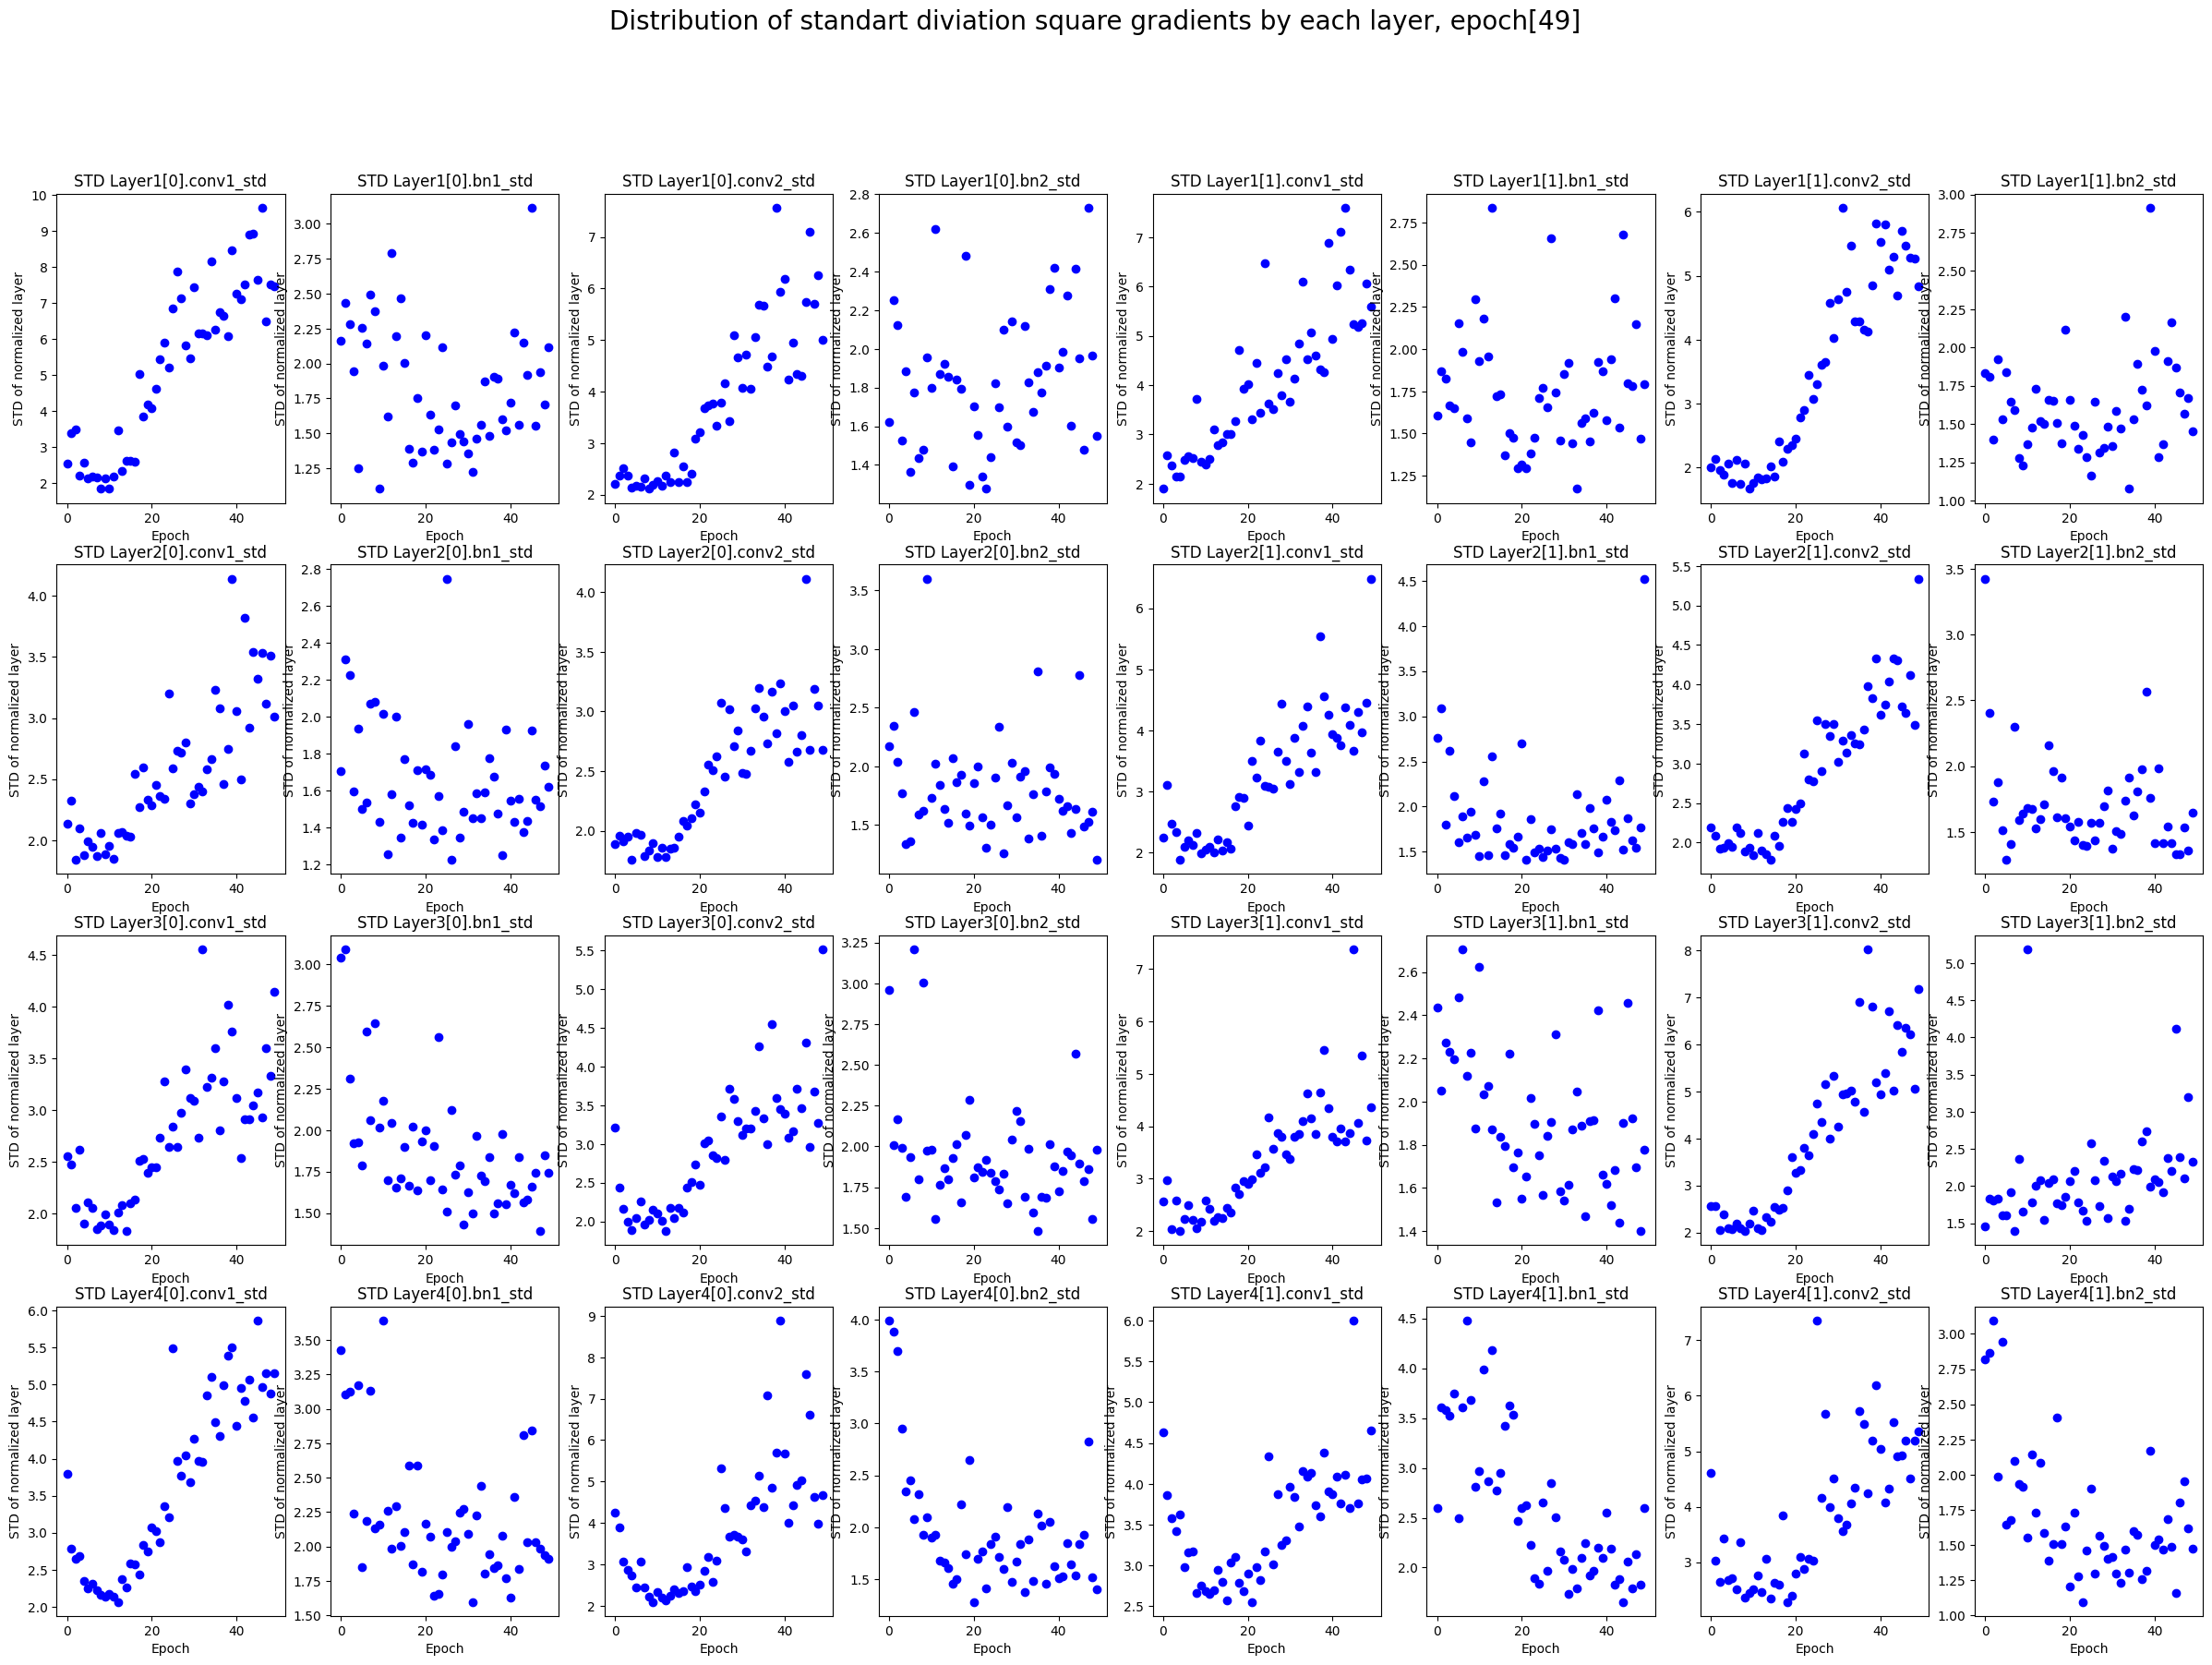

In [48]:
### new table
draw_table(table)

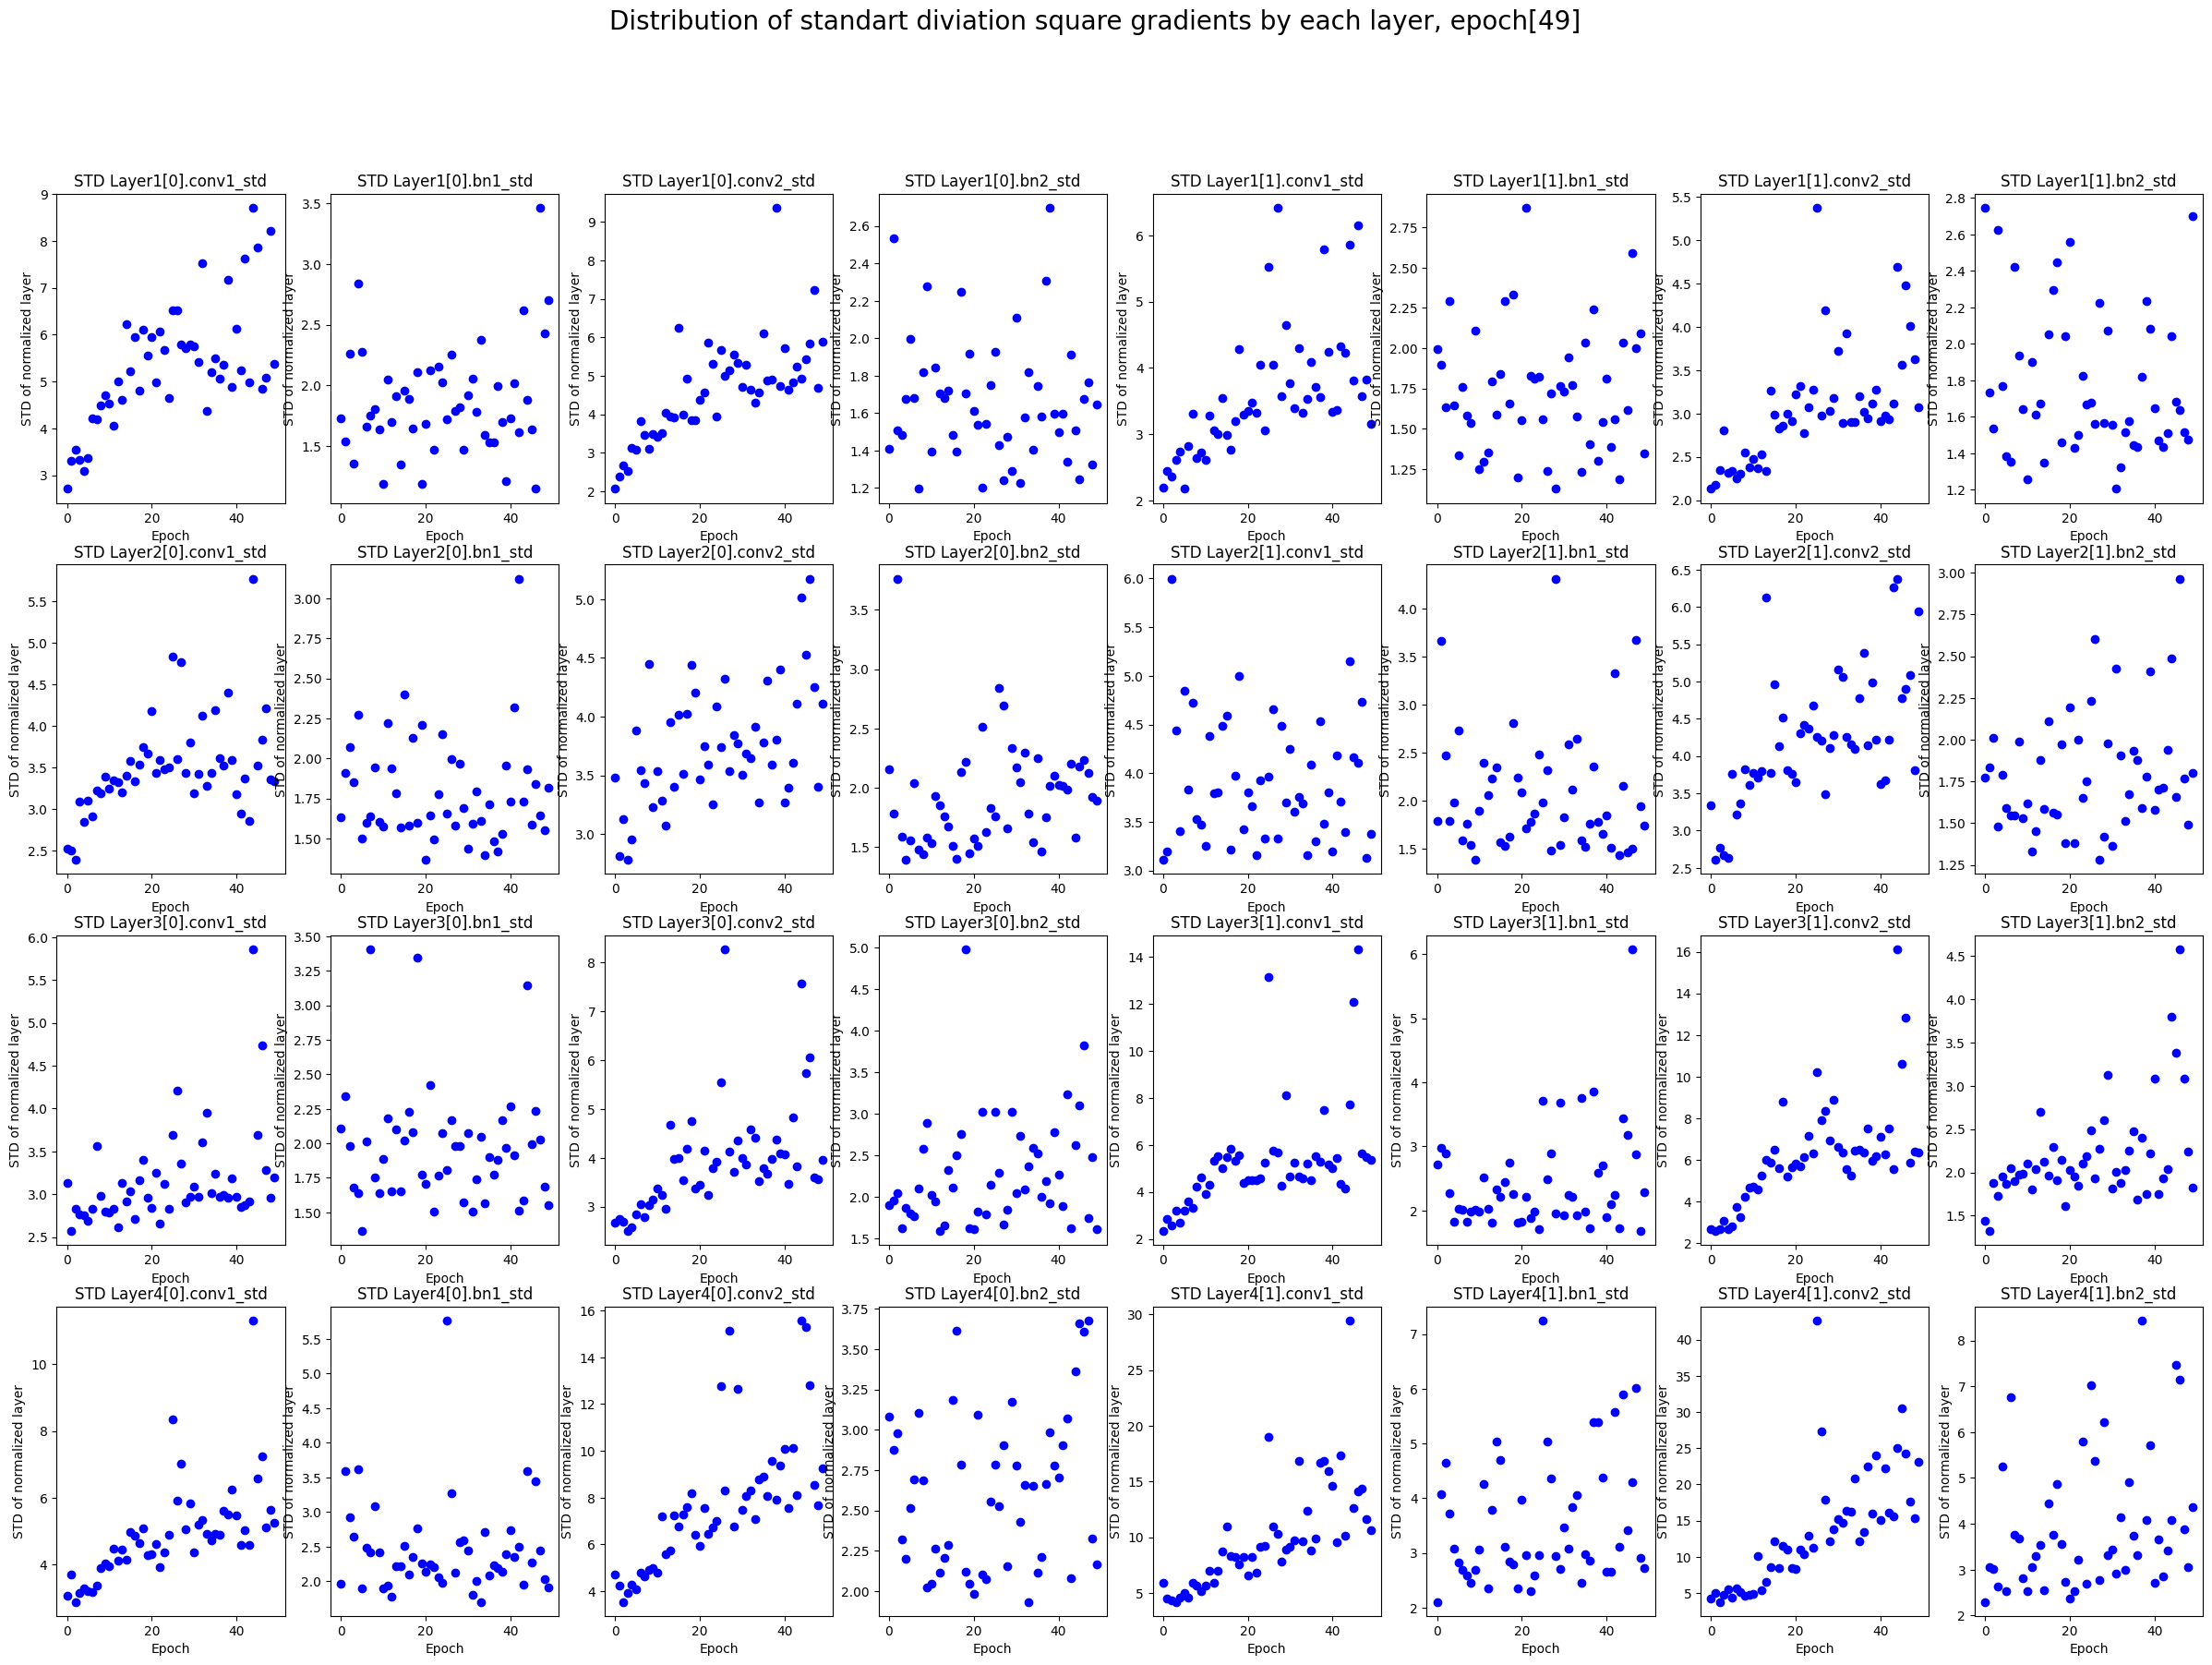

In [9]:
draw_table(table)

4 разных графика непохожих друга на друга

1(растущий) - Layer4[1].conv2_std
2(звездное небо) - Layer2[0].bn2_std
3(парабола) - Layer3[0].conv2_std
4(звездное небо прижатое к 1) - Layer2[1].bn1_std


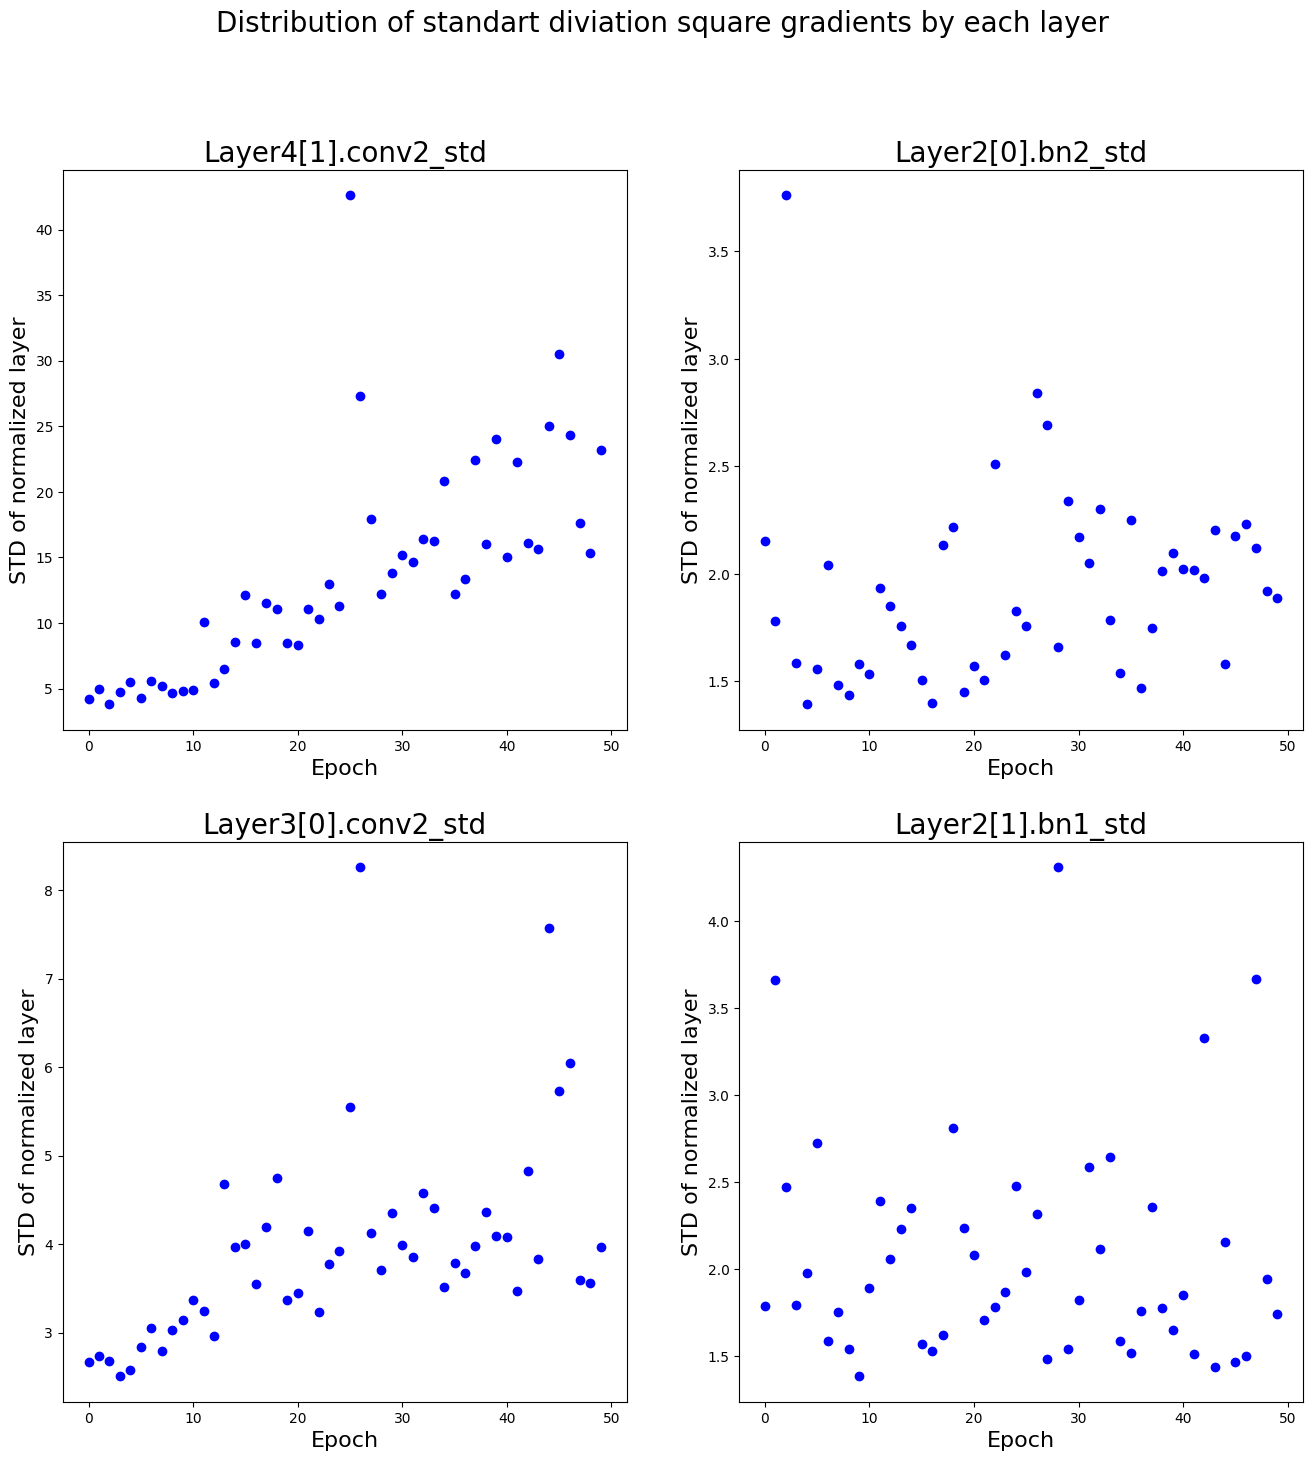

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
fig.suptitle(f"Distribution of standart diviation square gradients by each layer", fontsize=20)

column = 'Layer4[1].conv2_std'
name = '4-th layer second convolutional'
y = table[column]
x = [x for x in range(len(y))]        
axs[0, 0].scatter(x, y, c='blue')
axs[0, 0].set_title(f'{column}', fontsize=20)
axs[0, 0].set_xlabel(f'Epoch', fontsize=16)
axs[0, 0].set_ylabel(f'STD of normalized layer', fontsize=16)

column = 'Layer2[0].bn2_std'
name = '2-th layer second batch norm'
y = table[column]
x = [x for x in range(len(y))]        
axs[0, 1].scatter(x, y, c='blue')
axs[0, 1].set_title(f'{column}', fontsize=20)
axs[0, 1].set_xlabel(f'Epoch', fontsize=16)
axs[0, 1].set_ylabel(f'STD of normalized layer', fontsize=16)

column = 'Layer3[0].conv2_std'
y = table[column]
x = [x for x in range(len(y))]        
axs[1, 0].scatter(x, y, c='blue')
axs[1, 0].set_title(f'{column}', fontsize=20)
axs[1, 0].set_xlabel(f'Epoch', fontsize=16)
axs[1, 0].set_ylabel(f'STD of normalized layer', fontsize=16)

column = 'Layer2[1].bn1_std'
y = table[column]
x = [x for x in range(len(y))]        
axs[1, 1].scatter(x, y, c='blue')
axs[1, 1].set_title(f'{column}', fontsize=20)
axs[1, 1].set_xlabel(f'Epoch', fontsize=16)
axs[1, 1].set_ylabel(f'STD of normalized layer', fontsize=16)
plt.savefig(f"layers.png")
plt.show()

In [62]:
#x.shape
y.shape
x.shape

(50,)

In [31]:
from sklearn.linear_model import LinearRegression 
model = LinearRegression()
column = 'Layer4[1].conv2_std'
y = table[column].values
x = np.array([[x] for x in range(len(y))])
model.fit(x, y)
y_pred = model.predict(x)

In [30]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=25)
#plt.rc('figure', figsize=(12, 8))

In [41]:
table =pd.read_excel("output_new.xlsx")  

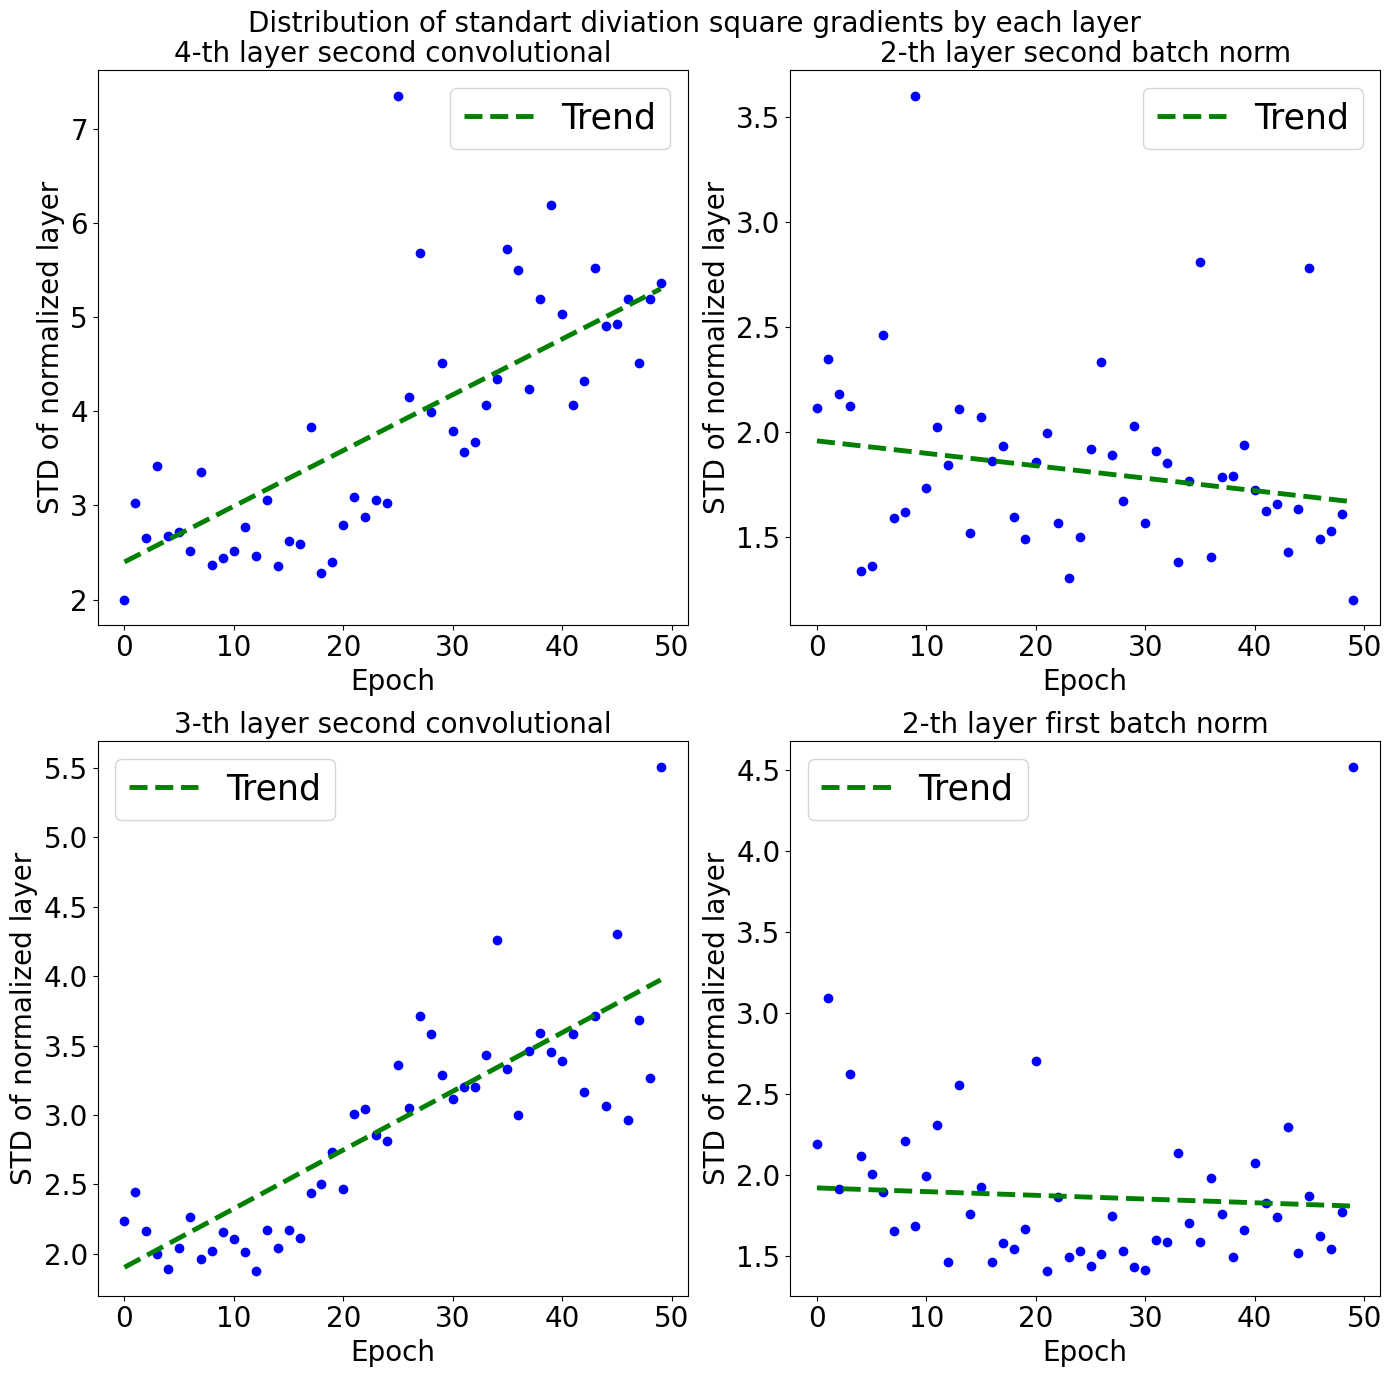

In [42]:
# new table
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
fig.suptitle(f"Distribution of standart diviation square gradients by each layer", fontsize=20)

column = 'Layer4[1].conv2_std'
name = '4-th layer second convolutional'
y = table[column].values.copy()
y[0] = 2
x = [x for x in range(len(y))]        
axs[0, 0].scatter(x, y, c='blue')
model = LinearRegression()
y = table[column].values
x = np.array([[x] for x in range(len(y))])
model.fit(x, y)
y_pred = model.predict(x)
axs[0, 0].plot(x, y_pred, c='green', linestyle='dashed',  linewidth=3.5, label='Trend')
axs[0, 0].set_title(f'{name}', fontsize=20)
axs[0, 0].set_xlabel(f'Epoch', fontsize=20)
axs[0, 0].set_ylabel(f'STD of normalized layer', fontsize=20)
axs[0, 0].legend()

column = 'Layer2[0].bn2_std'
name = '2-th layer second batch norm'
y = table[column].values.copy()
x = [x for x in range(len(y))]        
axs[0, 1].scatter(x, y, c='blue')
model = LinearRegression()
y = table[column].values.copy()
x = np.array([[x] for x in range(len(y))])
model.fit(x, y)
y_pred = model.predict(x)
axs[0, 1].plot(x, y_pred, c='green', linestyle='dashed',  linewidth=3.5, label='Trend')
axs[0, 1].set_title(f'{name}', fontsize=20)
axs[0, 1].set_xlabel(f'Epoch', fontsize=20)
axs[0, 1].set_ylabel(f'STD of normalized layer', fontsize=20)
axs[0, 1].legend()

column = 'Layer3[0].conv2_std'
name = '3-th layer second convolutional'
y = table[column].values.copy()
x = [x for x in range(len(y))]        
axs[1, 0].scatter(x, y, c='blue')
model = LinearRegression()
y = table[column].values.copy()
x = np.array([[x] for x in range(len(y))])
model.fit(x, y)
y_pred = model.predict(x)
axs[1, 0].plot(x, y_pred, c='green', linestyle='dashed',  linewidth=3.5, label='Trend')
axs[1, 0].set_title(f'{name}', fontsize=20)
axs[1, 0].set_xlabel(f'Epoch', fontsize=20)
axs[1, 0].set_ylabel(f'STD of normalized layer', fontsize=20)
axs[1, 0].legend()

column = 'Layer2[1].bn1_std'
name = '2-th layer first batch norm'
y = table[column].values.copy()

x = [x for x in range(len(y))]        
axs[1, 1].scatter(x, y, c='blue')
model = LinearRegression()
y = table[column].values.copy()
x = np.array([[x] for x in range(len(y))])
model.fit(x, y)
y_pred = model.predict(x)
axs[1, 1].plot(x, y_pred, c='green', linestyle='dashed',  linewidth=3.5, label='Trend')
axs[1, 1].set_title(f'{name}', fontsize=20)
axs[1, 1].set_xlabel(f'Epoch', fontsize=20)
axs[1, 1].set_ylabel(f'STD of normalized layer', fontsize=20)
axs[1, 1].legend()
plt.savefig(f"layers.png")

plt.tight_layout()
plt.show()